# NAME: PRIYANG PATEL
# ID: 40230020

# **Transformer Text-To-Speech**

##Introduction

Despite breakthroughs in text-to-speech (TTS) synthesis, producing natural-sounding speech remains difficult. Traditional approaches fail to capture long-range relationships in text while keeping natural prosody, limiting their usefulness in practical applications. High-quality TTS systems have several applications, including assisting visually impaired users, creating audiobooks, and improving voice interfaces. To reach their full potential, TTS systems must use natural speech patterns and be computationally efficient. The main issues in TTS synthesis include capturing long-range relationships in text, balancing speech accuracy and naturalness, and assuring real-time creation for practical use cases. Previous TTS techniques, such Recurrent Neural Networks (RNNs) and Tacotron2, have made great progress. However, RNNs suffer with long-range dependencies, and Tacotron2, despite its advances, remains computationally costly. This study presents a transformer-based TTS model for the SpeechBrain framework. Transformers, noted for their capacity to capture long-range dependencies, appear to be a possible answer to the issues of TTS synthesis. Building on Tacotron2's design, use of SpeechBrain's efficiency and efficacy while implementing the model. Transformers have shown excellent performance in a variety of sequence-to-sequence tasks, making them ideal candidates for TTS synthesis. SpeechBrain offers a strong infrastructure for developing and optimizing TTS models, guaranteeing rapid development and deployment. The goal is to train and test the framework on the LJSpeech dataset, a popular benchmark for TTS synthesis. Performance evaluation will include comparisons to Tacotron2 based on human evaluation measures such as naturalness and audio quality. This project requires access to GPUs for efficient training, used Colab Pro v100 as computational resources.


## Methodology

This section describes the methodological approach used to implement the Transformer TTS model in the SpeechBrain environment, with the goal of delivering high-quality text-to-speech synthesis. The emphasis is on critical procedural components that significantly affected the project's efficacy, such as data preparation procedures, model architecture options, and training methodologies.

### ***DATA PREPARATION PROCEDURES***

#### DATASET AND JSON FILES
* **Dataset** : LJSpeech contains 13K text-to-voice pairings from a single speaker, with an average utterance duration of ~7 seconds and complete sizes of ~2.6 Gb.
* **Json Files** : The ljprepare.py function from SpeechBrain's Tacotron2 blueprint helped generate JSON-formatted datasets containing textual inputs, audio, and relevant features for training, validation, and testing.

#### TEXT DATA
* **Text transformation** : Firstly, the text is changed to lowercase for uniformity. After that, each character is handled individually. Every character, including special symbols like punctuation, has a unique number identification that is mapped to it via a dictionary. A character is just skipped if it cannot be found in the dictionary. Ultimately, a unique "EOS" sign is included to indicate that the text has finished.
Through this method, the text is effectively converted into a series of integers, each of which stands for a distinct character. To better understand and work with the text input, machine learning models are better suited to this numerical representation (tensor).

* **Why Characters?** : Characters provide simplicity in implementation and training, as they have a well-defined mapping to sounds. Additionally, they are adaptable, making it possible to handle new words and variants with elegance. Characters also use language cues like capitalization and punctuation, which go beyond speech, to communicate emotive force. Character-based models are also more advantageous for large-scale training since they are often more computationally efficient. Character-based models nonetheless need pre-processing in order to be normalised, notwithstanding these advantages.

* NOTE :- Not tried to train with Phonemes features (will be better)




#### AUDIA DATA

Audio signals are typically represented as a dependency of amplitude versus time, denoted as f(time) → amplitude. By visualizing this waveform, we can observe the variations in amplitude over time. However, to delve deeper into signal analysis, we utilize the frequency domain through techniques like the Fast Fourier Transform (FFT), which yields the dependency of power versus frequency, denoted as g(frequency) → power. The Short-time Fourier Transform (STFT) amalgamates both time and frequency domains by employing window transformations, enabling the analysis of signal components over short intervals. Additionally, the MEL scale is employed to account for the uneven perception of frequencies by human hearing, thereby reducing the dimensionality of the signal by discarding less relevant frequencies. For audio reconstruction from spectrograms, approaches such as vocoders, involving separate neural network models, or the Griffin-Lim algorithm, based on phase reconstruction using the redundancy of the STFT, are utilized.


 This many approaches are available:
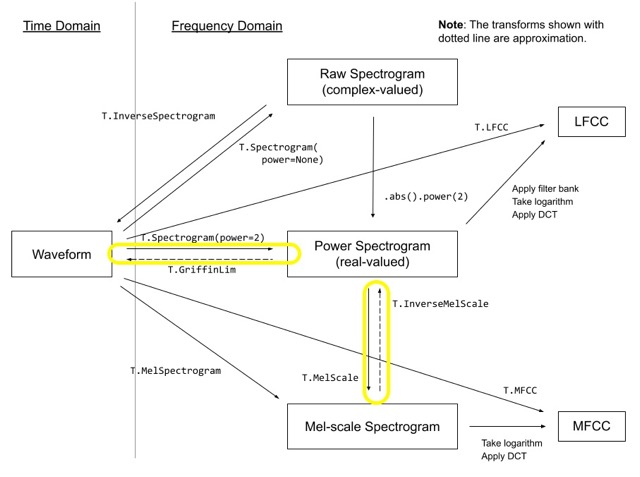

 [sorce] https://pytorch.org/audio/stable/transforms.html


Out of which Highlighted in the Yellow is the one I have used in this work





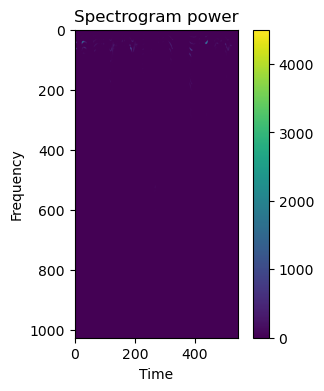

In [2]:
import torch
import torchaudio
from torchaudio import transforms
import matplotlib.pyplot as plt

spec_transform = torchaudio.transforms.Spectrogram(
    n_fft=2048,
    win_length=1024,
    hop_length=256,
    power=2.0
)

wav_path = f"./extracted_data/LJSpeech-1.1/wavs/LJ023-0073.wav"
waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
spec = spec_transform(waveform)

# Plot spectrogram-power
fig, ax1 = plt.subplots(figsize=(4, 4))
ax1.set_title("Spectrogram power")
pos = ax1.imshow(spec.squeeze(0).detach().cpu().numpy())
fig.colorbar(pos, ax=ax1)
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency")

plt.show()


Here is where the issue is apparent: the data is visually difficult to differentiate in this format (have a look at the lower frequencies; something is still discernible there). This implies that it will be challenging for the model to learn to discern patterns and differentiate between different portions of the data during training.


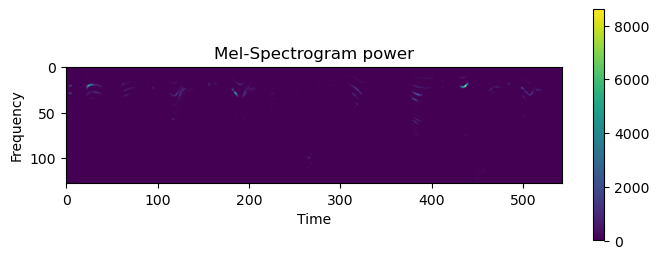

In [3]:
import torch
import torchaudio
from torchaudio import transforms
import matplotlib.pyplot as plt

spec_transform = transforms.Spectrogram(
    n_fft=2048,
    win_length=1024,
    hop_length=256,
    power=2.0
)

wav_path = f"./extracted_data/LJSpeech-1.1/wavs/LJ023-0073.wav"
waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
spec = spec_transform(waveform)

mel_scale_transform = transforms.MelScale(
    n_mels=128,
    sample_rate=22050,
    n_stft=1025
)

# Convert spectrogram-power to mel-spectrogram-power
mel_spec = mel_scale_transform(spec)

# Plot mel-spectrogram-power
fig, ax1 = plt.subplots(figsize=(8, 3))
ax1.set_title("Mel-Spectrogram power")
pos = ax1.imshow(mel_spec.squeeze(0).detach().cpu().numpy())
fig.colorbar(pos, ax=ax1)
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency")

plt.show()


Even with the data dimension lowered, the picture is still not very recognisable. This is because there isn't as much of an absolute energy differential at different frequencies. The change to decibels is used to emphasise the difference.

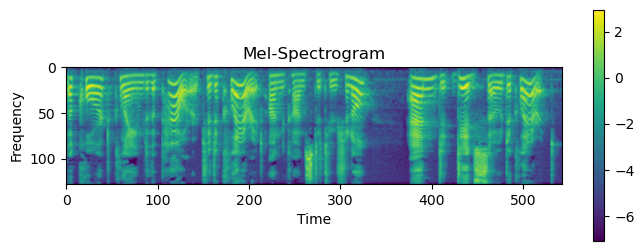

In [4]:
import torch
import torchaudio
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython
def power_to_db_mel_spec(mel_spec):
    mel_spec_db = torchaudio.functional.amplitude_to_DB(
        mel_spec,
        multiplier=10,
        amin=1e-10,
        db_multiplier=1.0,
        top_db=100
    )
    mel_spec_db = mel_spec_db / 10
    return mel_spec_db

spec_transform = transforms.Spectrogram(
    n_fft=2048,
    win_length=1024,
    hop_length=256,
    power=2.0
)



wav_path = f"./extracted_data/LJSpeech-1.1/wavs/LJ023-0073.wav"
waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
spec = spec_transform(waveform)

mel_scale_transform = transforms.MelScale(
    n_mels=128,
    sample_rate=22050,
    n_stft=1025
)

# Convert spectrogram-power to mel-spectrogram-power
mel_spec = mel_scale_transform(spec)

# Convert mel-spectrogram-power to mel-spectrogram-db
db_mel_spec = power_to_db_mel_spec(mel_spec)

# Plot mel-spectrogram-db
fig, ax1 = plt.subplots(figsize=(8, 3), ncols=1)
ax1.set_title("Mel-Spectrogram")
pos = ax1.imshow(db_mel_spec.squeeze(0).detach().cpu().numpy())
fig.colorbar(pos, ax=ax1)
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency")

plt.show()


# Regenerating audio from melspectogram
def dbToPowerMelSpec(mel_spec):
        mel_spec = mel_spec*10
        mel_spec = torchaudio.functional.DB_to_amplitude(
            mel_spec,
            ref=1,
            power=1.0
        )
        return mel_spec

InverseMelTransform = torchaudio.transforms.InverseMelScale(
        n_mels=128,
        sample_rate=22050,
        n_stft=1025
        )

griffnlimTransform = torchaudio.transforms.GriffinLim(
            n_fft=2048,
            win_length=1024,
            hop_length=256
        )

def inverse_mel_spec_to_wav(mel_spec):
        power_mel_spec = dbToPowerMelSpec(mel_spec)
        spectrogram = InverseMelTransform(power_mel_spec)
        generated_wav = griffnlimTransform(spectrogram)
        return generated_wav


pseudo_audio = inverse_mel_spec_to_wav(mel_spec=db_mel_spec.squeeze(0))

IPython.display.Audio(
    pseudo_audio.detach().cpu().numpy(),
    rate=22050
)

While these transformations condense the data, they also sacrifice some level of detail. However, the resulting representation is more manageable and suitable for tasks like feature extraction and analysis in audio processing applications.

#### JSON DATA

Used ljspeech_prepare.pyy file of tacatron2 implemented in speechbrain

In [5]:

%%file ljspeech_prepare.py
"""
LJspeech data preparation.
Download: https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

Authors
 * Yingzhi WANG 2022
 * Sathvik Udupa 2022
 * Pradnya Kandarkar 2023
"""
# from speechbrain.inference.text import GraphemeToPhoneme
import os
import csv
import json
import random
import logging
import torch
import torchaudio
import numpy as np
from tqdm import tqdm
from speechbrain.utils.data_utils import download_file
from speechbrain.dataio.dataio import load_pkl, save_pkl
import re
import tgt
from unidecode import unidecode
from speechbrain.utils.text_to_sequence import _g2p_keep_punctuations


logger = logging.getLogger(__name__)
OPT_FILE = "opt_ljspeech_prepare.pkl"
METADATA_CSV = "metadata.csv"
TRAIN_JSON = "train.json"
VALID_JSON = "valid.json"
TEST_JSON = "test.json"
WAVS = "wavs"
DURATIONS = "durations"

logger = logging.getLogger(__name__)
OPT_FILE = "opt_ljspeech_prepare.pkl"


def prepare_ljspeech(
    data_folder,
    save_folder,
    splits=["train", "valid"],
    split_ratio=[90, 10],
    model_name=None,
    seed=1234,
    pitch_n_fft=1024,
    pitch_hop_length=256,
    pitch_min_f0=65,
    pitch_max_f0=400,
    skip_prep=False,
    use_custom_cleaner=False,
    device="mps:0",
):
    """
    Prepares the csv files for the LJspeech datasets.

    Arguments
    ---------
    data_folder : str
        Path to the folder where the original LJspeech dataset is stored
    save_folder : str
        The directory where to store the csv/json files
    splits : list
        List of dataset splits to prepare
    split_ratio : list
        Proportion for dataset splits
    model_name : str
        Model name (used to prepare additional model specific data)
    seed : int
        Random seed
    pitch_n_fft : int
        Number of fft points for pitch computation
    pitch_hop_length : int
        Hop length for pitch computation
    pitch_min_f0 : int
        Minimum f0 for pitch compuation
    pitch_max_f0 : int
        Max f0 for pitch computation
    skip_prep : bool
        If True, skip preparation
    use_custom_cleaner : bool
        If True, uses custom cleaner defined for this recipe
    device : str
        Device for to be used for computation (used as required)

    Returns
    -------
    None

    Example
    -------
    >>> from recipes.LJSpeech.TTS.ljspeech_prepare import prepare_ljspeech
    >>> data_folder = 'data/LJspeech/'
    >>> save_folder = 'save/'
    >>> splits = ['train', 'valid']
    >>> split_ratio = [90, 10]
    >>> seed = 1234
    >>> prepare_ljspeech(data_folder, save_folder, splits, split_ratio, seed)
    """
    # Sets seeds for reproducible code
    random.seed(seed)

    if skip_prep:
        return

    # Creating configuration for easily skipping data_preparation stage
    conf = {
        "data_folder": data_folder,
        "splits": splits,
        "split_ratio": split_ratio,
        "save_folder": save_folder,
        "seed": seed,
    }
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Setting ouput files
    meta_csv = os.path.join(data_folder, METADATA_CSV)
    wavs_folder = os.path.join(data_folder, WAVS)

    save_opt = os.path.join(save_folder, OPT_FILE)
    save_json_train = os.path.join(save_folder, TRAIN_JSON)
    save_json_valid = os.path.join(save_folder, VALID_JSON)
    save_json_test = os.path.join(save_folder, TEST_JSON)

    phoneme_alignments_folder = None
    duration_folder = None
    pitch_folder = None
    # Setting up additional folders required for FastSpeech2
    if model_name is not None and "FastSpeech2" in model_name:
        # This step requires phoneme alignements to be present in the data_folder
        # We automatically donwload the alignments from https://www.dropbox.com/s/v28x5ldqqa288pu/LJSpeech.zip
        # Download and unzip LJSpeech phoneme alignments from here: https://drive.google.com/drive/folders/1DBRkALpPd6FL9gjHMmMEdHODmkgNIIK4
        alignment_URL = (
            "https://www.dropbox.com/s/v28x5ldqqa288pu/LJSpeech.zip?dl=1"
        )
        phoneme_alignments_folder = os.path.join(
            data_folder, "TextGrid", "LJSpeech"
        )
        download_file(
            alignment_URL, data_folder + "/alligments.zip", unpack=True
        )

        duration_folder = os.path.join(data_folder, "durations")
        if not os.path.exists(duration_folder):
            os.makedirs(duration_folder)

        # extract pitch for both Fastspeech2 and FastSpeech2WithAligner models
        pitch_folder = os.path.join(data_folder, "pitch")
        if not os.path.exists(pitch_folder):
            os.makedirs(pitch_folder)

    # Check if this phase is already done (if so, skip it)
    if skip(splits, save_folder, conf):
        logger.info("Skipping preparation, completed in previous run.")
        return

    # Additional check to make sure metadata.csv and wavs folder exists
    assert os.path.exists(meta_csv), "metadata.csv does not exist"
    assert os.path.exists(wavs_folder), "wavs/ folder does not exist"

    # Prepare data splits
    msg = "Creating json file for ljspeech Dataset.."
    logger.info(msg)
    data_split, meta_csv = split_sets(data_folder, splits, split_ratio)

    if "train" in splits:
        prepare_json(
            model_name,
            data_split["train"],
            save_json_train,
            wavs_folder,
            meta_csv,
            phoneme_alignments_folder,
            duration_folder,
            pitch_folder,
            pitch_n_fft,
            pitch_hop_length,
            pitch_min_f0,
            pitch_max_f0,
            use_custom_cleaner,
            device,
        )
    if "valid" in splits:
        prepare_json(
            model_name,
            data_split["valid"],
            save_json_valid,
            wavs_folder,
            meta_csv,
            phoneme_alignments_folder,
            duration_folder,
            pitch_folder,
            pitch_n_fft,
            pitch_hop_length,
            pitch_min_f0,
            pitch_max_f0,
            use_custom_cleaner,
            device,
        )
    if "test" in splits:
        prepare_json(
            model_name,
            data_split["test"],
            save_json_test,
            wavs_folder,
            meta_csv,
            phoneme_alignments_folder,
            duration_folder,
            pitch_folder,
            pitch_n_fft,
            pitch_hop_length,
            pitch_min_f0,
            pitch_max_f0,
            use_custom_cleaner,
            device,
        )
    save_pkl(conf, save_opt)


def skip(splits, save_folder, conf):
    """
    Detects if the ljspeech data_preparation has been already done.
    If the preparation has been done, we can skip it.

    Returns
    -------
    bool
        if True, the preparation phase can be skipped.
        if False, it must be done.
    """
    # Checking json files
    skip = True

    split_files = {
        "train": TRAIN_JSON,
        "valid": VALID_JSON,
        "test": TEST_JSON,
    }

    for split in splits:
        if not os.path.isfile(os.path.join(save_folder, split_files[split])):
            skip = False

    #  Checking saved options
    save_opt = os.path.join(save_folder, OPT_FILE)
    if skip is True:
        if os.path.isfile(save_opt):
            opts_old = load_pkl(save_opt)
            if opts_old == conf:
                skip = True
            else:
                skip = False
        else:
            skip = False
    return skip


def split_sets(data_folder, splits, split_ratio):
    """Randomly splits the wav list into training, validation, and test lists.
    Note that a better approach is to make sure that all the classes have the
    same proportion of samples for each session.

    Arguments
    ---------
    wav_list : list
        list of all the signals in the dataset
    split_ratio: list
        List composed of three integers that sets split ratios for train,
        valid, and test sets, respectively.
        For instance split_ratio=[80, 10, 10] will assign 80% of the sentences
        to training, 10% for validation, and 10% for test.

    Returns
    ------
    dictionary containing train, valid, and test splits.
    """
    meta_csv = os.path.join(data_folder, METADATA_CSV)
    csv_reader = csv.reader(
        open(meta_csv, encoding="utf8"), delimiter="|", quoting=csv.QUOTE_NONE
    )

    meta_csv = list(csv_reader)

    index_for_sessions = []
    session_id_start = "LJ001"
    index_this_session = []
    for i in range(len(meta_csv)):
        session_id = meta_csv[i][0].split("-")[0]
        if session_id == session_id_start:
            index_this_session.append(i)
            if i == len(meta_csv) - 1:
                index_for_sessions.append(index_this_session)
        else:
            index_for_sessions.append(index_this_session)
            session_id_start = session_id
            index_this_session = [i]

    session_len = [len(session) for session in index_for_sessions]

    data_split = {}
    for i, split in enumerate(splits):
        data_split[split] = []
        for j in range(len(index_for_sessions)):
            if split == "train":
                random.shuffle(index_for_sessions[j])
                n_snts = int(session_len[j] * split_ratio[i] / sum(split_ratio))
                data_split[split].extend(index_for_sessions[j][0:n_snts])
                del index_for_sessions[j][0:n_snts]
            if split == "valid":
                if "test" in splits:
                    random.shuffle(index_for_sessions[j])
                    n_snts = int(
                        session_len[j] * split_ratio[i] / sum(split_ratio)
                    )
                    data_split[split].extend(index_for_sessions[j][0:n_snts])
                    del index_for_sessions[j][0:n_snts]
                else:
                    data_split[split].extend(index_for_sessions[j])
            if split == "test":
                data_split[split].extend(index_for_sessions[j])

    return data_split, meta_csv


def prepare_json(
    model_name,
    seg_lst,
    json_file,
    wavs_folder,
    csv_reader,
    phoneme_alignments_folder,
    durations_folder,
    pitch_folder,
    pitch_n_fft,
    pitch_hop_length,
    pitch_min_f0,
    pitch_max_f0,
    use_custom_cleaner=False,
    device="mps:0",
):
    """
    Creates json file given a list of indexes.

    Arguments
    ---------
    model_name : str
        Model name (used to prepare additional model specific data)
    seg_lst : list
        The list of json indexes of a given data split
    json_file : str
        Output json path
    wavs_folder : str
        LJspeech wavs folder
    csv_reader : _csv.reader
        LJspeech metadata
    phoneme_alignments_folder : path
        Path where the phoneme alignments are stored
    durations_folder : path
        Folder where to store the duration values of each audio
    pitch_folder : path
        Folder where to store the pitch of each audio
    pitch_n_fft : int
        Number of fft points for pitch computation
    pitch_hop_length : int
        Hop length for pitch computation
    pitch_min_f0 : int
        Minimum f0 for pitch compuation
    pitch_max_f0 : int
        Max f0 for pitch computation
    use_custom_cleaner : bool
        If True, uses custom cleaner defined for this recipe
    device : str
        Device for to be used for computation (used as required)

    Returns
    -------
    None
    """

    logger.info(f"preparing {json_file}.")
    if model_name in ["Tacotron2", "FastSpeech2WithAlignment"]:
        logger.info(
            "Computing phonemes for LJSpeech labels using SpeechBrain G2P. This may take a while."
        )
        g2p = GraphemeToPhoneme.from_hparams(
            "speechbrain/soundchoice-g2p", run_opts={"device": device}
        )
    if model_name is not None and "FastSpeech2" in model_name:
        logger.info(
            "Computing pitch as required for FastSpeech2. This may take a while."
        )

    json_dict = {}
    for index in tqdm(seg_lst):
        # Common data preparation
        id = list(csv_reader)[index][0]
        wav = os.path.join(wavs_folder, f"{id}.wav")
        label = list(csv_reader)[index][2]
        if use_custom_cleaner:
            label = custom_clean(label, model_name)

        json_dict[id] = {
            "uttid": id,
            "wav": wav,
            "label": label,
            "segment": True if "train" in json_file else False,
        }

        # FastSpeech2 specific data preparation
        if model_name == "FastSpeech2":
            audio, fs = torchaudio.load(wav)

            # Parses phoneme alignments
            textgrid_path = os.path.join(
                phoneme_alignments_folder, f"{id}.TextGrid"
            )
            textgrid = tgt.io.read_textgrid(
                textgrid_path, include_empty_intervals=True
            )

            last_phoneme_flags = get_last_phoneme_info(
                textgrid.get_tier_by_name("words"),
                textgrid.get_tier_by_name("phones"),
            )
            (
                phonemes,
                duration,
                start,
                end,
                trimmed_last_phoneme_flags,
            ) = get_alignment(
                textgrid.get_tier_by_name("phones"),
                fs,
                pitch_hop_length,
                last_phoneme_flags,
            )

            # Gets label phonemes
            label_phoneme = " ".join(phonemes)
            spn_labels = [0] * len(phonemes)
            for i in range(1, len(phonemes)):
                if phonemes[i] == "spn":
                    spn_labels[i - 1] = 1
            if start >= end:
                print(f"Skipping {id}")
                continue

            # Saves durations
            duration_file_path = os.path.join(durations_folder, f"{id}.npy")
            np.save(duration_file_path, duration)

            # Computes pitch
            audio = audio[:, int(fs * start) : int(fs * end)]
            pitch_file = wav.replace(".wav", ".npy").replace(
                wavs_folder, pitch_folder
            )
            if not os.path.isfile(pitch_file):
                pitch = torchaudio.functional.detect_pitch_frequency(
                    waveform=audio,
                    sample_rate=fs,
                    frame_time=(pitch_hop_length / fs),
                    win_length=3,
                    freq_low=pitch_min_f0,
                    freq_high=pitch_max_f0,
                ).squeeze(0)

                # Concatenate last element to match duration.
                pitch = torch.cat([pitch, pitch[-1].unsqueeze(0)])

                # Mean and Variance Normalization
                mean = 256.1732939688805
                std = 328.319759158607

                pitch = (pitch - mean) / std

                pitch = pitch[: sum(duration)]
                np.save(pitch_file, pitch)

            # Updates data for the utterance
            json_dict[id].update({"label_phoneme": label_phoneme})
            json_dict[id].update({"spn_labels": spn_labels})
            json_dict[id].update({"start": start})
            json_dict[id].update({"end": end})
            json_dict[id].update({"durations": duration_file_path})
            json_dict[id].update({"pitch": pitch_file})
            json_dict[id].update(
                {"last_phoneme_flags": trimmed_last_phoneme_flags}
            )

        # FastSpeech2WithAlignment specific data preparation
        if model_name == "FastSpeech2WithAlignment":
            audio, fs = torchaudio.load(wav)
            # Computes pitch
            pitch_file = wav.replace(".wav", ".npy").replace(
                wavs_folder, pitch_folder
            )
            if not os.path.isfile(pitch_file):

                if torchaudio.__version__ < "2.1":
                    pitch = torchaudio.functional.compute_kaldi_pitch(
                        waveform=audio,
                        sample_rate=fs,
                        frame_length=(pitch_n_fft / fs * 1000),
                        frame_shift=(pitch_hop_length / fs * 1000),
                        min_f0=pitch_min_f0,
                        max_f0=pitch_max_f0,
                    )[0, :, 0]
                else:
                    pitch = torchaudio.functional.detect_pitch_frequency(
                        waveform=audio,
                        sample_rate=fs,
                        frame_time=(pitch_hop_length / fs),
                        win_length=3,
                        freq_low=pitch_min_f0,
                        freq_high=pitch_max_f0,
                    ).squeeze(0)

                    # Concatenate last element to match duration.
                    pitch = torch.cat([pitch, pitch[-1].unsqueeze(0)])

                    # Mean and Variance Normalization
                    mean = 256.1732939688805
                    std = 328.319759158607

                    pitch = (pitch - mean) / std

                np.save(pitch_file, pitch)

            phonemes = _g2p_keep_punctuations(g2p, label)
            # Updates data for the utterance
            json_dict[id].update({"phonemes": phonemes})
            json_dict[id].update({"pitch": pitch_file})
            # Check if the maximum number of records is reached
        # if len(json_dict) >= 50:
        #     break  # Exit the loop if maximum records reached
    # Writing the dictionary to the json file
    with open(json_file, mode="w") as json_f:
        json.dump(json_dict, json_f, indent=2)

    logger.info(f"{json_file} successfully created!")


def get_alignment(tier, sampling_rate, hop_length, last_phoneme_flags):
    """
    Returns phonemes, phoneme durations (in frames), start time (in seconds), end time (in seconds).
    This function is adopted from https://github.com/ming024/FastSpeech2/blob/master/preprocessor/preprocessor.py

    Arguments
    ---------
    tier : tgt.core.IntervalTier
        For an utterance, contains Interval objects for phonemes and their start time and end time in seconds
    sampling_rate : int
        Sample rate if audio signal
    hop_length : int
        Hop length for duration computation
    last_phoneme_flags : list
        List of (phoneme, flag) tuples with flag=1 if the phoneme is the last phoneme else flag=0


    Returns
    -------
    (phones, durations, start_time, end_time) : tuple
        The phonemes, durations, start time, and end time for an utterance
    """

    sil_phones = ["sil", "sp", "spn", ""]

    phonemes = []
    durations = []
    start_time = 0
    end_time = 0
    end_idx = 0
    trimmed_last_phoneme_flags = []

    flag_iter = iter(last_phoneme_flags)

    for t in tier._objects:
        s, e, p = t.start_time, t.end_time, t.text
        current_flag = next(flag_iter)

        # Trims leading silences
        if phonemes == []:
            if p in sil_phones:
                continue
            else:
                start_time = s

        if p not in sil_phones:
            # For ordinary phones
            # Removes stress indicators
            if p[-1].isdigit():
                phonemes.append(p[:-1])
            else:
                phonemes.append(p)
            trimmed_last_phoneme_flags.append(current_flag[1])
            end_time = e
            end_idx = len(phonemes)
        else:
            # Uses a unique token for all silent phones
            phonemes.append("spn")
            trimmed_last_phoneme_flags.append(current_flag[1])

        durations.append(
            int(
                np.round(e * sampling_rate / hop_length)
                - np.round(s * sampling_rate / hop_length)
            )
        )

    # Trims tailing silences
    phonemes = phonemes[:end_idx]
    durations = durations[:end_idx]

    return phonemes, durations, start_time, end_time, trimmed_last_phoneme_flags


def get_last_phoneme_info(words_seq, phones_seq):
    """This function takes word and phoneme tiers from a TextGrid file as input
    and provides a list of tuples for the phoneme sequence indicating whether
    each of the phonemes is the last phoneme of a word or not.

    Each tuple of the returned list has this format: (phoneme, flag)


    Arguments
    ---------
    words_seq :
        word tier from a TextGrid file
    phones_seq :
        phoneme tier from a TextGrid file

    Returns
    -------
    last_phoneme_flags : list
        each tuple of the returned list has this format: (phoneme, flag)
    """

    # Gets all phoneme objects for the entire sequence
    phoneme_objects = phones_seq._objects
    phoneme_iter = iter(phoneme_objects)

    # Stores flags to show if an element (phoneme) is a the last phoneme of a word
    last_phoneme_flags = list()

    # Matches the end times of the phoneme and word objects to get the last phoneme information
    for word_obj in words_seq._objects:
        word_end_time = word_obj.end_time

        current_phoneme = next(phoneme_iter, None)
        while current_phoneme:
            phoneme_end_time = current_phoneme.end_time
            if phoneme_end_time == word_end_time:
                last_phoneme_flags.append((current_phoneme.text, 1))
                break
            else:
                last_phoneme_flags.append((current_phoneme.text, 0))
            current_phoneme = next(phoneme_iter, None)

    return last_phoneme_flags


def custom_clean(text, model_name):
    """
    Uses custom criteria to clean text.

    Arguments
    ---------
    text : str
        Input text to be cleaned
    model_name : str
        whether to treat punctuations

    Returns
    -------
    text : str
        Cleaned text
    """

    _abbreviations = [
        (re.compile("\\b%s\\." % x[0], re.IGNORECASE), x[1])
        for x in [
            ("mrs", "misess"),
            ("mr", "mister"),
            ("dr", "doctor"),
            ("st", "saint"),
            ("co", "company"),
            ("jr", "junior"),
            ("maj", "major"),
            ("gen", "general"),
            ("drs", "doctors"),
            ("rev", "reverend"),
            ("lt", "lieutenant"),
            ("hon", "honorable"),
            ("sgt", "sergeant"),
            ("capt", "captain"),
            ("esq", "esquire"),
            ("ltd", "limited"),
            ("col", "colonel"),
            ("ft", "fort"),
        ]
    ]
    text = unidecode(text.lower())
    if model_name != "FastSpeech2WithAlignment":
        text = re.sub("[:;]", " - ", text)
        text = re.sub(r'[)(\[\]"]', " ", text)
        text = text.strip().strip().strip("-")

    text = re.sub(" +", " ", text)
    for regex, replacement in _abbreviations:
        text = re.sub(regex, replacement, text)
    return text


Writing ljspeech_prepare.py


### DATASET

In [5]:
import tarfile
import os
# URL for the LJSpeech dataset
url = 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'

# Dataset path to save the LJSpeech dataset
download_path = './LJSpeech-1.1.tar.bz2'

# Download the LJSpeech dataset
!gdown $url -O $download_path
print("Dataset downloaded successfully!")

# Unzip the LJSpeech dataset
!tar -jxf LJSpeech-1.1.tar.bz2
# Path to your LJSpeech-1.1.tar.bz2 file
tar_file_path = "./LJSpeech-1.1.tar.bz2"

# Directory where you want to extract the data
extracted_dir = "extracted_data"

# Create the target directory if it doesn't exist
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Open the tar.bz2 file
with tarfile.open(tar_file_path, 'r:bz2') as tar:
    # Extract all datas to the target directory
    tar.extractall(extracted_dir)

print(f"Data extracted to: {extracted_dir}")

Downloading...
From: https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
To: /content/LJSpeech-1.1.tar.bz2
2.75GB [02:04, 22.0MB/s]
Dataset downloaded successfully!
Data extracted to: extracted_data


### MODEL

Implementation of Transformer TTS model

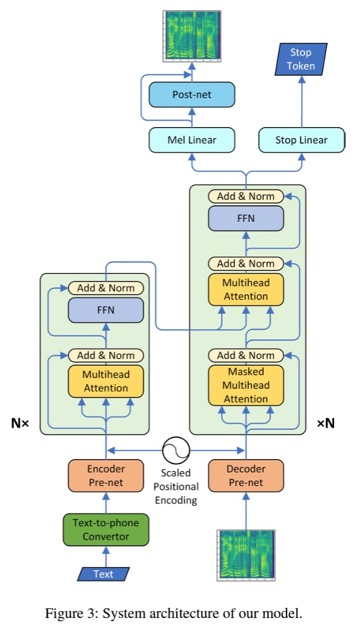


(IMPORTANT) STOP TOKEN : The stop token mechanism is vital in autoregressive models, particularly in text-to-speech systems. It functions as a signal to indicate when audio creation should stop. The stop token tensor is organised similarly to an aligned spectrogram, and its length corresponds to the time dimension.


#### Custom Collet :
A custom collate function has been developed to consolidate individual data samples into batches, a critical phase in dataset preparation. The model architecture facilitates flexible dimensions for text and audio lengths, facilitating efficient alignment of sequences within each batch. In contrast to conventional methods aligning samples based on the maximum size across the entire dataset, the approach emphasizes maximizing alignment within each batch. This methodology minimizes computational overhead and circumvents superfluous data manipulation. Ultimately, the custom collate function optimizes dataset formation, ensuring optimal resource utilization and enhancing model training efficacy.



#### TTSLoss Class:
TTSLoss is a custom loss function designed for training text-to-speech (TTS) models. It combines multiple loss components including Mean Squared Error (MSE) loss and Binary Cross Entropy (BCE) loss to optimize the model's performance.

Note: Took reference from Tacatron2 implementation of speechbrain
(source) https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/inference/TTS.html#Tacotron2

#### AudioFeatureExtractor Class:

The AudioFeatureExtractor class encapsulates a set of functionalities for audio preprocessing, including text-to-sequence conversion, spectrogram computation, amplitude scaling, and audio generation. It serves as a comprehensive tool for facilitating various stages of audio processing within TTS systems.

**IMPORTANT**:

[source] https://arxiv.org/pdf/1712.05884 To add output variation at inference time, dropout with probability 0.5 is applied just to the autoregressive decoder's pre-network layers.

For implementation of the Transformer TTS model I have taken references:
*   [Tacatron2 Speechbrain](https://github.com/techthiyanes/speechbrain/blob/d71a7e018738329fe9a7951d2e9457d52f94edad/recipes/LJSpeech/TTS/tacotron2/train.py)
*   [Simple Transformer TTS](https://github.com/tttzof351/SimpleTransfromerTTS/tree/master)
* [Tacatron2 Implementation of model](https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/inference/TTS.html#Tacotron2)


#### Model code

In [6]:
%%file model.py


import math
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchaudio import transforms
import pandas as pd
from tqdm import tqdm
from collections import namedtuple
import torchaudio


class EncoderBlock(nn.Module):
    """
    An encoder block for a Transformer-based model.

    The encoder block consists of a multi-head attention layer followed by a feedforward neural network.
    Layer normalization and residual connections are used to improve the stability and performance of the model.

    Arguments:
    ---------
        embedding_size : int
                       The size of the input and output embeddings.
        dim_feedforward : int
                        The size of the hidden layer in the feedforward neural network.

    """
    def __init__(self,embedding_size,dim_feedforward):
        super(EncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(normalized_shape=embedding_size)
        self.attn = torch.nn.MultiheadAttention(embed_dim=embedding_size,num_heads=4,dropout=0.1,batch_first=True)
        self.dropout1 = torch.nn.Dropout(0.1)
        self.norm2 = nn.LayerNorm(normalized_shape=embedding_size)
        self.linear1 = nn.Linear(embedding_size,dim_feedforward)
        self.dropout2 = torch.nn.Dropout(0.1)
        self.linear2 = nn.Linear(dim_feedforward,embedding_size)
        self.dropout3 = torch.nn.Dropout(0.1)

    def forward(self,x,attention_mask=None,key_padding_mask=None):
        """
        Forward pass through the encoder block.

        Arguments:
        ---------
            x : torch.Tensor
              The input tensor of shape (batch_size, sequence_length, embedding_size).
            attention_mask : torch.Tensor , optional
                      The attention mask tensor, with shape (sequence_length, sequence_length).
                      Defaults to None.
            key_padding_mask : torch.Tensor, optional
                             The key padding mask tensor, with shape (batch_size, sequence_length).
                             Defaults to None.
        """
        residual = x
        x_t = self.norm1(x)
        x_t, _ = self.attn(query=x_t,key=x_t,value=x_t,attn_mask=attention_mask,key_padding_mask=key_padding_mask)
        x_t = self.dropout1(x_t)
        x = residual + x_t
        residual = x
        x_t = self.norm2(x)
        x_t = self.linear1(x_t)
        x_t = F.relu(x_t)
        x_t = self.dropout2(x_t)
        x_t = self.linear2(x_t)
        x_t = self.dropout3(x_t)
        x = residual + x_t
        return x


class DecoderBlock(nn.Module):
    """
    A decoder block for a Transformer-based model.

    The decoder block consists of a self-attention layer, a cross-attention layer, and a feedforward neural network.
    Layer normalization and residual connections are used to improve the stability and performance of the model.

    Arguments:
    ---------
        embedding_size : int
                       The size of the input and output embeddings.
        dim_feedforward : int
                        The size of the hidden layer in the feedforward neural network.
    """
    def __init__(self,embedding_size,dim_feedforward):
        super(DecoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(normalized_shape=embedding_size)
        self.self_attn = torch.nn.MultiheadAttention(embed_dim=embedding_size,num_heads=4,dropout=0.1,batch_first=True)
        self.dropout1 = torch.nn.Dropout(0.1)
        self.norm2 = nn.LayerNorm(normalized_shape=embedding_size)
        self.attn = torch.nn.MultiheadAttention(embed_dim=embedding_size,num_heads=4,dropout=0.1,batch_first=True)
        self.dropout2 = torch.nn.Dropout(0.1)
        self.norm3 = nn.LayerNorm(normalized_shape=embedding_size)
        self.linear1 = nn.Linear(embedding_size,dim_feedforward)
        self.dropout3 = torch.nn.Dropout(0.1)
        self.linear2 = nn.Linear(dim_feedforward,embedding_size)
        self.dropout4 = torch.nn.Dropout(0.1)

    def forward(self,x,memory,x_attention_mask=None,x_key_padding_mask=None,memory_attention_mask=None,memory_key_padding_mask=None):
        """
        Forward pass through the decoder block.

        Arguments:
        ---------
            x : torch.Tensor
              The input tensor of shape (batch_size, sequence_length, embedding_size).
            memory : torch.Tensor
                   The memory tensor from the encoder, of shape (batch_size, memory_length, embedding_size).
            x_attn_mask : torch.Tensor, optional
                        The attention mask tensor for the input tensor `x`,
                        with shape (sequence_length, sequence_length). Defaults to None.
            x_key_padding_mask : torch.Tensor, optional
                               The key padding mask tensor for the input tensor `x`,
                               with shape (batch_size, sequence_length). Defaults to None.
            memory_attn_mask : torch.Tensor, optional
                             The attention mask tensor for the memory tensor,
                             with shape (sequence_length, memory_length). Defaults to None.
            memory_key_padding_mask : torch.Tensor, optional
                                    The key padding mask tensor for the memory tensor,
                                    with shape (batch_size, memory_length). Defaults to None.
        """
        x_t, _ = self.self_attn(query=x,key=x,value=x,attn_mask=x_attention_mask,key_padding_mask=x_key_padding_mask)
        x_t = self.dropout1(x_t)
        x = self.norm1(x + x_t)
        x_t, _ = self.attn(query=x,key=memory,value=memory,attn_mask=memory_attention_mask,key_padding_mask=memory_key_padding_mask)
        x_t = self.dropout2(x_t)
        x = self.norm2(x + x_t)
        x_t = self.linear1(x)
        x_t = F.relu(x_t)
        x_t = self.dropout3(x_t)
        x_t = self.linear2(x_t)
        x_t = self.dropout4(x_t)
        x = self.norm3(x + x_t)
        return x


class EncoderPreNet(nn.Module):
    """
    The purpose of the EncoderPreNet class is to preprocess the input text before it is passed to the encoder part of the Transformer-based TTS
    model. The preprocessing involves embedding the text, applying convolutional layers, and finally transforming the embeddings to the desired
    size.

    Arguments:
    ----------
    embedding_size : The size of the input and output embeddings.
    encoder_embedding_size : This parameter represents the size of the intermediate feature representations
                            (embeddings) that the EncoderPreNet will learn. It determines the number of output
                            channels for the convolutional layers.
    encoder_kernel_size : The size of the convolutional kernels used in the EncoderPreNet.
                         It determines the receptive field of the convolutional layers, i.e., the amount of input
                         context that each output feature will have access to.

    """
    def __init__(self,text_num_embeddings,encoder_embedding_size,embedding_size,encoder_kernel_size):
        super(EncoderPreNet, self).__init__()

        self.embedding = nn.Embedding( num_embeddings=text_num_embeddings,embedding_dim=encoder_embedding_size)
        self.linear1 = nn.Linear(encoder_embedding_size,encoder_embedding_size)
        self.linear2 = nn.Linear(encoder_embedding_size,embedding_size)
        self.conv1 = nn.Conv1d(encoder_embedding_size,encoder_embedding_size,kernel_size=encoder_kernel_size,stride=1,padding=int((encoder_kernel_size - 1) / 2),dilation=1)
        self.bn1 = nn.BatchNorm1d(encoder_embedding_size)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(encoder_embedding_size,encoder_embedding_size,kernel_size=encoder_kernel_size,stride=1,padding=int((encoder_kernel_size - 1) / 2),dilation=1)
        self.bn2 = nn.BatchNorm1d(encoder_embedding_size)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.conv3 = nn.Conv1d(encoder_embedding_size,encoder_embedding_size,kernel_size=encoder_kernel_size,stride=1,padding=int((encoder_kernel_size - 1) / 2),dilation=1)
        self.bn3 = nn.BatchNorm1d(encoder_embedding_size)
        self.dropout3 = torch.nn.Dropout(0.5)

    def forward(self, text):
        """
        Arguments:
        ---------
        text: torch.Tensor
            The tensor of token IDs, where each row represents a sample in the batch, and each column represents a token in the input sequence.
        """
        x = self.embedding(text)
        x = self.linear1(x)

        x = x.transpose(2, 1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = x.transpose(1, 2)
        x = self.linear2(x)

        return x


class PostNet(nn.Module):
    """
    The purpose of the PostNet class is to further refine the mel spectrogram output from the previous module in the TTS model.
    It uses a series of 1D convolutional layers, batch normalization, and dropout to apply non-linear transformations to the input,
    effectively post-processing the mel spectrogram to improve its quality.

    Arguments:
    ---------
    postnet_embedding_size: int
        This parameter represents the number of output channels (or the embedding size) for the convolutional
        layers in the PostNet. It determines the size of the intermediate feature representations that the
        PostNet will learn during the forward pass.
    postnet_kernel_size: int
        This parameter represents the size of the convolutional kernels used in the PostNet
    mel_freq: int
        This parameter represents the number of mel frequency bins in the input mel spectrogram.

    """
    def __init__(self,mel_freq,postnet_embedding_size,postnet_kernel_size):
        super(PostNet, self).__init__()

        self.conv1 = nn.Conv1d(mel_freq,postnet_embedding_size,kernel_size=postnet_kernel_size,stride=1,padding=int((postnet_kernel_size - 1) / 2),dilation=1)
        self.bn1 = nn.BatchNorm1d(postnet_embedding_size)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(postnet_embedding_size,postnet_embedding_size,kernel_size=postnet_kernel_size,stride=1,padding=int((postnet_kernel_size - 1) / 2),dilation=1)
        self.bn2 = nn.BatchNorm1d(postnet_embedding_size)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.conv3 = nn.Conv1d(postnet_embedding_size,postnet_embedding_size,kernel_size=postnet_kernel_size,stride=1,padding=int((postnet_kernel_size - 1) / 2),dilation=1)
        self.bn3 = nn.BatchNorm1d(postnet_embedding_size)
        self.dropout3 = torch.nn.Dropout(0.5)
        self.conv4 = nn.Conv1d(postnet_embedding_size,postnet_embedding_size,kernel_size=postnet_kernel_size,stride=1,padding=int((postnet_kernel_size - 1) / 2),dilation=1)
        self.bn4 = nn.BatchNorm1d(postnet_embedding_size)
        self.dropout4 = torch.nn.Dropout(0.5)
        self.conv5 = nn.Conv1d(postnet_embedding_size,postnet_embedding_size,kernel_size=postnet_kernel_size,stride=1,padding=int((postnet_kernel_size - 1) / 2),dilation=1)
        self.bn5 = nn.BatchNorm1d(postnet_embedding_size)
        self.dropout5 = torch.nn.Dropout(0.5)
        self.conv6 = nn.Conv1d(postnet_embedding_size,mel_freq,kernel_size=postnet_kernel_size,stride=1,padding=int((postnet_kernel_size - 1) / 2),dilation=1)
        self.bn6 = nn.BatchNorm1d(mel_freq)
        self.dropout_6 = torch.nn.Dropout(0.5)

    def forward(self, x):
        """
        x : torch.Tensor
          The input x is first transposed to have the shape (N, FREQ, TIME), where N is the batch size,
          FREQ is the number of mel frequency bins, and TIME is the number of time steps. The input is then
          passed through the six sets of convolutional, batch normalization, and dropout layers. Each layer
          applies a non-linear transformation to the input, with the final layer outputting a tensor of
          size (N, FREQ, TIME). The output tensor is then transposed back to the original shape (N, TIME, FREQ)
          and returned
        """
        x = x.transpose(2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.tanh(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.tanh(x)
        x = self.dropout3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.tanh(x)
        x = self.dropout4(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = torch.tanh(x)
        x = self.dropout5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.dropout_6(x)
        x = x.transpose(1, 2)
        return x


class DecoderPreNet(nn.Module):
    """
    The purpose of the DecoderPreNet is to apply a transformation to the target
    mel spectrogram before it is fed into the Decoder. This preprocessing can help
    the model learn a better representation of the input, which can improve the overall
    performance of the TTS system.

    Arguments:
    ---------
    mel_freq: int
        The mel_freq parameter represents the number of mel frequency bins in the mel spectrogram.
        This determines the resolution of the frequency representation.
    embedding_size: int
        The embedding_size parameter represents the dimensionality of the
        learned embeddings or feature representations in the model.

    """
    def __init__(self,mel_freq,embedding_size):
        super(DecoderPreNet, self).__init__()
        self.linear1 = nn.Linear(mel_freq,embedding_size)
        self.linear2 = nn.Linear(embedding_size,embedding_size)

    def forward(self, x):
        """
        Arguments:
        ---------
        x: torch.Tensor
            The target mel spectrogram
        """
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=True)
        x = self.linear2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=True)
        return x

class TransformerTTS(nn.Module):
    """
    A Transformer-based Text-to-Speech (TTS) model.

    The TransformerTTS model is a Transformer-based architecture for generating mel spectrograms from input text.
    It consists of an encoder that processes the input text, a decoder that generates the output mel spectrogram,
    and a postnet that refines the generated mel spectrogram.

    Arguments:
    ---------
        device : str, optional
                The device to run the model on.
        max_mel_time : int, optional
                     The maximum length of the output mel spectrogram. Defaults to 1024.
        embedding_size : int, optional
                       The size of the input and output embeddings. Defaults to 256.
        mel_freq : int, optional
                 The number of mel frequency bins. Defaults to 128.
        dim_feedforward : int, optional
                        The size of the hidden layer in the feedforward neural networks. Defaults to 1024.
        encoder_embedding_size : int, optional
                               The size of the encoder's input embeddings. Defaults to 512.
        encoder_kernel_size : int, optional
                            The kernel size of the encoder's convolutional layers. Defaults to 3.
        postnet_embedding_size : int, optional
                               The size of the postnet's hidden layer. Defaults to 1024.
        postnet_kernel_size : int, optional
                            The kernel size of the postnet's convolutional layers. Defaults to 5.
    """
    def __init__(self, device,text_num_embeddings,embedding_size,encoder_embedding_size,dim_feedforward,postnet_embedding_size,encoder_kernel_size,postnet_kernel_size,max_mel_time,mel_freq):
        super(TransformerTTS, self).__init__()
        self.device = device
        self.text_num_embeddings = text_num_embeddings
        self.embedding_size = embedding_size
        self.encoder_embedding_size = encoder_embedding_size
        self.dim_feedforward = dim_feedforward
        self.postnet_embedding_size = postnet_embedding_size
        self.encoder_kernel_size = encoder_kernel_size
        self.postnet_kernel_size = postnet_kernel_size
        self.max_mel_time = max_mel_time
        self.mel_freq=mel_freq
        self.encoder_prenet = EncoderPreNet(self.text_num_embeddings,self.encoder_embedding_size,self.embedding_size,self.encoder_kernel_size)
        self.decoder_prenet = DecoderPreNet(self.mel_freq,self.embedding_size)
        self.postnet = PostNet(self.mel_freq,self.postnet_embedding_size,self.postnet_kernel_size)
        self.pos_encoding = nn.Embedding(num_embeddings=self.max_mel_time,embedding_dim=self.embedding_size)
        self.eb_1 = EncoderBlock(self.embedding_size,self.dim_feedforward)
        self.eb_2 = EncoderBlock(self.embedding_size,self.dim_feedforward)
        self.eb_3 = EncoderBlock(self.embedding_size,self.dim_feedforward)
        self.db_1 = DecoderBlock(self.embedding_size,self.dim_feedforward)
        self.db_2 = DecoderBlock(self.embedding_size,self.dim_feedforward)
        self.db_3 = DecoderBlock(self.embedding_size,self.dim_feedforward)
        self.linear1 = nn.Linear(self.embedding_size, self.mel_freq)
        self.linear2 = nn.Linear(self.embedding_size, 1)
        self.norm_memory = nn.LayerNorm(normalized_shape=self.embedding_size)

    def forward(self,text,text_len,mel,mel_len):
        """
        Forward pass through the TransformerTTS model.

        Arguments:
        ---------
            text : torch.Tensor
                 The input text tensor of shape (batch_size, sequence_length).
            text_len : torch.Tensor
                     The lengths of the input text sequences, of shape (batch_size,).
            mel : torch.Tensor
                The target mel spectrogram tensor of shape (batch_size, time_steps, mel_freq).
            mel_len : torch.Tensor
                    The lengths of the target mel spectrograms, of shape (batch_size,).
        """
        N = text.shape[0]
        S = text.shape[1]
        TIME = mel.shape[1]
        self.src_key_padding_mask = torch.zeros((N, S),device=text.device).masked_fill(~maskFromSequenceLengths(text_len,max_length=S),float("-inf"))
        self.src_mask = torch.zeros((S, S),device=text.device).masked_fill(torch.triu(torch.full((S, S),True,dtype=torch.bool),diagonal=1).to(text.device),float("-inf"))
        self.tgt_key_padding_mask = torch.zeros((N, TIME),device=mel.device).masked_fill(~maskFromSequenceLengths(mel_len,max_length=TIME),float("-inf"))
        self.tgt_mask = torch.zeros((TIME, TIME),device=mel.device).masked_fill(torch.triu(torch.full((TIME, TIME),True,device=mel.device,dtype=torch.bool),diagonal=1),float("-inf"))
        self.memory_mask = torch.zeros((TIME, S),device=mel.device).masked_fill(torch.triu(torch.full((TIME, S),True,device=mel.device,dtype=torch.bool),diagonal=1),float("-inf"))
        text_x = self.encoder_prenet(text)
        pos_codes = self.pos_encoding(torch.arange(self.max_mel_time).to(mel.device))
        S = text_x.shape[1]
        text_x = text_x + pos_codes[:S]
        text_x = self.eb_1(text_x,attention_mask=self.src_mask,key_padding_mask=self.src_key_padding_mask)
        text_x = self.eb_2(text_x,attention_mask=self.src_mask,key_padding_mask=self.src_key_padding_mask)
        text_x = self.eb_3(text_x,attention_mask=self.src_mask,key_padding_mask=self.src_key_padding_mask)
        text_x = self.norm_memory(text_x)
        mel_x = self.decoder_prenet(mel)
        mel_x = mel_x + pos_codes[:TIME]
        mel_x = self.db_1(x=mel_x,memory=text_x,x_attention_mask=self.tgt_mask,x_key_padding_mask=self.tgt_key_padding_mask,memory_attention_mask=self.memory_mask,memory_key_padding_mask=self.src_key_padding_mask)
        mel_x = self.db_2(x=mel_x,memory=text_x,x_attention_mask=self.tgt_mask,x_key_padding_mask=self.tgt_key_padding_mask,memory_attention_mask=self.memory_mask,memory_key_padding_mask=self.src_key_padding_mask)
        mel_x = self.db_3(x=mel_x,memory=text_x,x_attention_mask=self.tgt_mask,x_key_padding_mask=self.tgt_key_padding_mask,memory_attention_mask=self.memory_mask,memory_key_padding_mask=self.src_key_padding_mask)  # (N, TIME, E)
        mel_linear = self.linear1(mel_x)
        mel_postnet = self.postnet(mel_linear)
        mel_postnet = mel_linear + mel_postnet
        stop_token = self.linear2(mel_x)
        bool_mel_mask = self.tgt_key_padding_mask.ne(0).unsqueeze(-1).repeat(1, 1, self.mel_freq)
        mel_linear = mel_linear.masked_fill(bool_mel_mask,0)
        mel_postnet = mel_postnet.masked_fill(bool_mel_mask,0)
        stop_token = stop_token.masked_fill(bool_mel_mask[:, :, 0].unsqueeze(-1),1e3).squeeze(2)
        return mel_postnet, mel_linear, stop_token

    @torch.no_grad()
    def inference(self, text, max_length=800, stop_token_threshold=1e-5, with_tqdm=True):
        self.eval()
        self.train(False)
        textLengths = torch.tensor(text.shape[1]).unsqueeze(0).to(self.device)
        N = 1
        SOS = torch.zeros((N, 1, self.mel_freq)).to(self.device)

        melPadded = SOS
        melLengths = torch.tensor(1).unsqueeze(0).to(self.device)
        stop_token_outputs = torch.FloatTensor([]).to(text.device)

        if with_tqdm:
            iters = tqdm(range(max_length))
        else:
            iters = range(max_length)

        for _ in iters:
            mel_postnet, mel_linear, stop_token = self(
                text.to(self.device),
                textLengths.to(self.device),
                melPadded.to(self.device),
                melLengths.to(self.device)
            )

            melPadded = torch.cat(
                [
                    melPadded.to(self.device),
                    mel_postnet[:, -1:, :].to(self.device)
                ],
                dim=1
            )
            if torch.sigmoid(stop_token[:, -1]) > stop_token_threshold:
                break
            else:
                stop_token_outputs = torch.cat([stop_token_outputs.to(self.device), stop_token[:,-1:].to(self.device)], dim=1)
                melLengths = torch.tensor(
                    melPadded.shape[1]).unsqueeze(0).to(self.device)

        return mel_postnet,stop_token_outputs





LossStats = namedtuple(
    "TTSLoss", "loss mel_loss stop_token_loss"
)


class TTSLoss(torch.nn.Module):
    """
    TTSLoss is a custom loss function designed for training text-to-speech (TTS) models.
    It combines multiple loss components including Mean Squared Error (MSE) loss and
    Binary Cross Entropy (BCE) loss to optimize the model's performance.

    Arguments:
    ---------
    None

    Methods:
    --------
    forward:
        Computes the loss for a batch of predictions and targets.

    """
    def __init__(self):
        super(TTSLoss, self).__init__()

        self.mse_loss = torch.nn.MSELoss()
        self.bce_loss = torch.nn.BCEWithLogitsLoss()

    def forward(
        self,
        mel_postnet_out,
        mel_out,
        stop_token_out,
        mel_target,
        stop_token_target
    ):
        """
        Compute the loss for a batch of predictions and targets.

        Arguments:
        ----------
        mel_postnet_out: torch.Tensor
            Predicted mel-spectrogram after the post-processing network.

        mel_out: torch.Tensor
            Predicted mel-spectrogram.

        stop_token_out: torch.Tensor
            Predicted stop token indicating the end of the audio sequence.

        mel_target: torch.Tensor
            Target mel-spectrogram.

        stop_token_target: torch.Tensor
            Target stop token.

        Returns:
        --------
        LossStats:
            A named tuple containing the total loss, mel-spectrogram loss, and stop token loss.
        """
        stop_token_target = stop_token_target.view(-1, 1)

        stop_token_out = stop_token_out.view(-1, 1)
        mel_loss = self.mse_loss(mel_out, mel_target) + \
            self.mse_loss(mel_postnet_out, mel_target)

        stop_token_loss = self.bce_loss(
            stop_token_out, stop_token_target) * 1.0

        return LossStats(mel_loss + stop_token_loss, mel_loss, stop_token_loss)



def maskFromSequenceLengths(
    seq_lengths: torch.Tensor,
    max_length: int
) -> torch.BoolTensor:
    """
        Create a mask tensor from the sequence lengths.

       Arguments:
       ---------
            seq_lengths : torch.Tensor
                        The lengths of the sequences, of shape (batch_size,).
            max_length : int
                       The maximum length of the sequences.
        example :
        --------
        our input was `[2, 2, 3]`, with a `max_length` of 4, we'd return
        `[[1, 1, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0]]`.
    """
    ones = seq_lengths.new_ones(seq_lengths.size(0), max_length)
    rangeTensor = ones.cumsum(dim=1)
    return seq_lengths.unsqueeze(1) >= rangeTensor




def TTSCollate(batch):
    """Collates a batch of text and mel spectrogram data for text-to-speech tasks.

    Arguments:
    ---------
        batch: A list of dictionaries, each containing 'text' and 'mel' tensors.

    Returns:
    -------
        A tuple containing:
            - text: Original text tensor (for reference).
            - textsPadded: Padded text tensor.
            - textLengths: Tensor of text lengths.
            - melsPadded: Padded mel spectrogram tensor.
            - melLengths: Tensor of mel spectrogram lengths.
            - stopTokenPadded: Padded stop token indicating sequence end.
    """
    maximumTextLength = torch.tensor([item['text'].shape[-1] for item in batch],dtype=torch.int32).max()
    MaximumMelLength = torch.tensor([item['mel'].shape[-1] for item in batch],dtype=torch.int32).max()

    textLengths = []
    melLengths = []
    textsPadded = []
    melsPadded = []

    for item in batch:
        text = item['text']
        mel = item['mel']
        textLength = item["text"].shape[-1]
        textPadded = torch.nn.functional.pad(text,pad=[0, maximumTextLength-textLength],value=0)
        melLength = item["mel"].shape[-1]
        melPadded = torch.nn.functional.pad(mel,pad=[0, MaximumMelLength-melLength],value=0)
        textLengths.append(textLength)
        melLengths.append(melLength)
        textsPadded.append(textPadded)
        melsPadded.append(melPadded)

    textLengths = torch.tensor(textLengths, dtype=torch.int32)
    melLengths = torch.tensor(melLengths, dtype=torch.int32)
    textsPadded = torch.stack(textsPadded, 0)
    melsPadded = torch.stack(melsPadded, 0).transpose(1, 2)

    stopTokenPadded = maskFromSequenceLengths(
        melLengths,
        MaximumMelLength
    )
    stopTokenPadded = (~stopTokenPadded).float()
    stopTokenPadded[:, -1] = 1.0

    return text, \
        textsPadded, \
        textLengths, \
        melsPadded, \
        melLengths, \
        stopTokenPadded \


class AudioFeatureExtractor:
    """
    n_fft : int
          Size of the Fast Fourier Transform (FFT) window.
    win_length : int
               Length of the window function applied to each frame.
    hop_length : int
               Number of samples to hop between frames.
    power : float
          Power exponent used in spectrogram calculation (e.g., 2 for power spectrogram).
    n_mels : int
           Number of Mel filters.
    sample_rate : int
                Sampling rate of the audio signal.
    n_stft : int
           Optional number of STFT (Short-Time Fourier Transform) windows, defaults to None (computed from audio length and hop length).
    max_db : float
           Maximum decibel value for normalization.
    norm_db : bool
            Whether to normalize Mel spectrogram to decibels before scaling.
    ampl_multiplier : float
                    Multiplier for amplitude-to-dB conversion.
    ampl_amin : float
              Minimum amplitude value for log-scaling in dB conversion.
    db_multiplier : float
                  Multiplier for scaling decibel values.
    scale_db : float
             Scaling factor for Mel spectrogram in decibels.
    ampl_ref : float
             Reference amplitude for dB-to-amplitude conversion.
    ampl_power : float
               Power for dB-to-amplitude conversion.
    mel_freq : int
             Optional number of Mel bins, defaults to n_mels (derived from Mel filterbank).
    """
    def __init__(self,sr = 22050,n_fft = 2048,n_stft = 1025,frame_shift = 0.0125,
                 hop_length = 256,frame_length = 0.05,win_length = 1024,mel_freq = 128,
                 max_mel_time = 1024,max_db = 100,scale_db = 10,ref = 4.0,power = 2.0,norm_db = 10 ,
                 ampl_multiplier = 10.0,ampl_amin = 1e-10,db_multiplier = 1.0,ampl_ref = 1.0,
                 ampl_power = 1.0):

        self.sr=sr
        self.n_fft=n_fft
        self.n_stft=n_stft
        self.frame_shift=frame_shift
        self.hop_length=hop_length
        self.frame_length=frame_length
        self.win_length=win_length
        self.mel_freq=mel_freq
        self.max_mel_time=max_mel_time
        self.max_db=max_db
        self.scale_db=scale_db
        self.ref=ref
        self.power=power
        self.norm_db=norm_db
        self.ampl_multiplier=ampl_multiplier
        self.ampl_amin=ampl_amin
        self.db_multiplier=db_multiplier
        self.ampl_ref=ampl_ref
        self.ampl_power=ampl_power

        self.symbols = [
                'EOS', ' ', '!', ',', '-', '.', \
                ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', \
                'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
                'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', \
                'â', 'è', 'é', 'ê', 'ü', '’', '“', '”' \
            ]

        self.specTransform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            power=power
        )

        self.melScaleTransform = torchaudio.transforms.MelScale(
        n_mels=mel_freq,
        sample_rate=sr,
        n_stft=n_stft
        )

        self.InverseMelTransform = torchaudio.transforms.InverseMelScale(
        n_mels=mel_freq,
        sample_rate=sr,
        n_stft=n_stft
        )

        self.griffnlimTransform = torchaudio.transforms.GriffinLim(
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length
        )

        self.symbol_to_id = {
            s: i for i, s in enumerate(self.symbols)
        }


    def text_to_seq(self,text):
        text = text.lower()
        seq = []
        for s in text:
            _id = self.symbol_to_id.get(s, None)
            if _id is not None:
                seq.append(_id)

        seq.append(self.symbol_to_id["EOS"])
        return torch.IntTensor(seq)


    def powerToDbMelSpec(self,mel_spec):
        mel_spec = torchaudio.functional.amplitude_to_DB(
            mel_spec,
            multiplier = self.ampl_multiplier,
            amin = self.ampl_amin,
            db_multiplier = self.db_multiplier,
            top_db = self.max_db
        )
        mel_spec = mel_spec/self.scale_db
        return mel_spec


    def dbToPowerMelSpec(self,mel_spec):
        mel_spec = mel_spec*self.scale_db
        mel_spec = torchaudio.functional.DB_to_amplitude(
            mel_spec,
            ref=self.ampl_ref,
            power=self.ampl_power
        )
        return mel_spec


    def GenerateToMelSpectogram(self,wav):
        spec = self.specTransform(wav)
        mel_spec = self.melScaleTransform(spec)
        db_mel_spec = self.powerToDbMelSpec(mel_spec)
        db_mel_spec = db_mel_spec.squeeze(0)
        return db_mel_spec


    def inverse_mel_spec_to_wav(self,mel_spec):
        power_mel_spec = self.dbToPowerMelSpec(mel_spec)
        spectrogram = self.InverseMelTransform(power_mel_spec)
        generated_wav = self.griffnlimTransform(spectrogram)
        return generated_wav


Writing model.py


#### Hparams yaml

In [7]:
%%file TransformerSpeech.yaml

seed: 1234
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref ./result/TTS/<seed>
save_folder: !ref ./result/save
train_log: !ref ./result/train_log.txt
epochs: 175
device: "cuda:0"
keep_checkpoint_interval: 50

################Data Files#################
# Data files and pre-processing #
data_folder: ./extracted_data/LJSpeech-1.1 # e.g, /localscratch/ljspeech

train_json: !ref <save_folder>/train.json
valid_json: !ref <save_folder>/valid.json
test_json: !ref <save_folder>/test.json

splits: ["train", "valid","test"]
split_ratio: [70, 20, 10]

skip_prep: False

# Use the original preprocessing from nvidia
# The cleaners to be used (applicable to nvidia only)
text_cleaners: ['english_cleaners']
#################################


###############Audio Params#################
# Sounds transformations params
sr: 22050
n_fft: 2048
n_stft: 1025
frame_shift: 0.0125
hop_length: 256
frame_length: 0.05
win_length: 1024
mel_freq: 128
max_mel_time: 1024
max_db: 100
scale_db: 10
ref: 4.0
power: 2.0
norm_db: 10
ampl_multiplier: 10.0
ampl_amin: 1e-10
db_multiplier: 1.0
ampl_ref: 1.0
ampl_power: 1.0
################################


#################Progress##################
# Progress Samples                #
# Progress samples are used to monitor the progress
# of an ongoing training session by outputting samples
# of spectrograms, alignments, etc at regular intervals
# Whether to enable progress samples
progress_samples: True

# The path where the samples will be stored
progress_sample_path: !ref ./result/samples
# The interval, in epochs. For instance, if it is set to 5,
# progress samples will be output every 5 epochs
progress_samples_interval: 1
# The sample size for raw batch samples saved in batch.pth
# (useful mostly for model debugging)
progress_batch_sample_size: 3

progress_sample_logger: !new:speechbrain.utils.train_logger.ProgressSampleLogger
  output_path: !ref <progress_sample_path>
  batch_sample_size: !ref <progress_batch_sample_size>
  formats:
    raw_batch: raw



###############Hyperparameters#################
# Optimization Hyperparameters #
lr_start: 0.001
lr_final: 0.0001
weight_decay: 0.000006
batch_size: 32 #minimum 2
num_workers: 0
text_num_embeddings : 86
embedding_size : 256
encoder_embedding_size : 512
dim_feedforward : 1024
postnet_embedding_size : 1024
encoder_kernel_size : 3
postnet_kernel_size : 5
grad_clip : 1.0
r_gate : 1.0

###############Data Processing################

audio_feature_extractor: !new:model.AudioFeatureExtractor
  sr: !ref <sr>
  n_fft: !ref <n_fft>
  n_stft: !ref <n_stft>
  frame_shift: !ref <frame_shift>
  hop_length: !ref <hop_length>
  frame_length: !ref <frame_length>
  win_length: !ref <win_length>
  mel_freq: !ref <mel_freq>
  max_mel_time: !ref <max_mel_time>
  max_db: !ref <max_db>
  scale_db: !ref <scale_db>
  ref: !ref <ref>
  power: !ref <power>
  norm_db: !ref <norm_db>
  ampl_multiplier: !ref <ampl_multiplier>
  ampl_amin: !ref <ampl_amin>
  db_multiplier: !ref <db_multiplier>
  ampl_ref: !ref <ampl_ref>
  ampl_power: !ref <ampl_power>


train_dataloader_opts:
  batch_size: !ref <batch_size>
  drop_last: False  #True #False
  num_workers: !ref <num_workers>
  collate_fn: !name:model.TTSCollate

valid_dataloader_opts:
  batch_size: !ref <batch_size>
  num_workers: !ref <num_workers>
  collate_fn: !name:model.TTSCollate

test_dataloader_opts:
  batch_size: !ref <batch_size>
  num_workers: !ref <num_workers>
  collate_fn: !name:model.TTSCollate


########### model ######################
model: !new:model.TransformerTTS
  device : !ref <device>
  text_num_embeddings: !ref <text_num_embeddings>
  embedding_size: !ref <embedding_size>
  encoder_embedding_size: !ref <encoder_embedding_size>
  dim_feedforward: !ref <dim_feedforward>
  postnet_embedding_size: !ref <postnet_embedding_size>
  encoder_kernel_size: !ref <encoder_kernel_size>
  postnet_kernel_size: !ref <postnet_kernel_size>
  max_mel_time: !ref <max_mel_time>
  mel_freq: !ref <mel_freq>

modules:
  model: !ref <model>

criterion: !new:model.TTSLoss

############optimizer#####################
opt_class: !name:torch.optim.Adam
  lr: !ref <lr_start>
  weight_decay: !ref <weight_decay>

###########epoch object###################
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
  limit: !ref <epochs>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
  save_file: !ref <train_log>

############annealing_function#############
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <epochs>

##################checkpointer###############
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
  checkpoints_dir: !ref <save_folder>
  recoverables:
    model: !ref <model>
    counter: !ref <epoch_counter>


pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        model: !ref <model>

# Text to sequence module
text_to_sequence: !new:model.AudioFeatureExtractor



Writing TransformerSpeech.yaml


#### Train.py

In [8]:
%%file train.py

import os
import pickle
import torch
import torch.nn as  nn
import numpy as np
import librosa
from librosa.feature import melspectrogram
from torch.nn.utils.rnn import pad_sequence
import torchaudio
import torch
import speechbrain as sb
import sys
import logging
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.text_to_sequence import text_to_sequence
from speechbrain.utils.data_utils import scalarize
import torch.nn as nn
import librosa
from librosa.feature import melspectrogram
logger = logging.getLogger(__name__)

class TTS(sb.Brain):
    def on_fit_start(self):
        """Gets called at the beginning of ``fit()``, on multiple processes
        if ``distributed_count > 0`` and backend is ddp and initializes statistics"""
        self.hparams.progress_sample_logger.reset()
        self.last_epoch = 0
        self.last_batch = None
        self.last_loss_stats = {}
        return super().on_fit_start()

    def compute_forward(self, batch, stage):
        """Computes the forward pass

        Arguments
        ---------
        batch: str
            a single batch
        stage: speechbrain.Stage
            the training stage

        Returns
        -------
        the model output
        """

        _,texts_padded,text_lengths,mels_padded,mel_lengths,_=batch
        return self.modules.model(texts_padded.to(self.device),text_lengths.to(self.device),mels_padded.to(self.device),mel_lengths.to(self.device))

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.
        Arguments
        ---------
        predictions : torch.Tensor
            The model generated spectrograms and other metrics from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        post_mel_out, mel_out, stop_token_out = predictions
        text,texts_padded,text_lengths,mels_padded,mel_lengths,stop_token_padded=batch
        self.last_batch = batch
        loss_stats = self.hparams.criterion(
          mel_postnet_out = post_mel_out.to(self.device),
          mel_out = mel_out.to(self.device),
          stop_token_out = stop_token_out.to(self.device),
          mel_target = mels_padded.to(self.device),
          stop_token_target = stop_token_padded.to(self.device)
        )
        self._remember_sample(batch, predictions)
        self.last_loss_stats[stage] = scalarize(loss_stats)
        return loss_stats.loss

    def _remember_sample(self, batch, predictions):
        """Remembers samples of spectrograms and the batch for logging purposes

        Arguments
        ---------
        batch: tuple
            a training batch
        predictions: tuple
            predictions (raw output of the Tacotron model)
        """
        post_mel_out, mel_out, stop_token_out = predictions
        text,texts_padded,text_lengths,mels_padded,mel_lengths,stop_token_padded=batch

        self.hparams.progress_sample_logger.remember(
            raw_batch=self.hparams.progress_sample_logger.get_batch_sample(
                {
                    "post_mel_out": post_mel_out,
                    "mel_out": mel_out,
                    "stop_token_out": stop_token_out,
                    "text":text,
                    "texts_padded": texts_padded,
                    "text_lengths": text_lengths,
                    "mels_padded": mels_padded,
                    "mel_lengths": mel_lengths,
                    "stop_token_padded": stop_token_padded
                }
            ),
        )

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        # At the end of validation, we can write
        if stage == sb.Stage.VALID:
            # Update learning rate
            # lr = self.optimizer.param_groups[-1]["lr"]
            # self.last_epoch = epoch
            # old_lr, new_lr = self.hparams.lr_annealing(epoch)
            # sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)
            lr = self.optimizer.param_groups[-1]["lr"]
            self.last_epoch = epoch

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch": epoch, "lr":  lr},
                train_stats=self.last_loss_stats[sb.Stage.TRAIN],
                valid_stats=self.last_loss_stats[sb.Stage.VALID],
            )

            # Save the current checkpoint and delete previous checkpoints.
            epoch_metadata = {
                **{"epoch": epoch},
                **self.last_loss_stats[sb.Stage.VALID],
            }
            self.checkpointer.save_and_keep_only(
                meta=epoch_metadata,
                min_keys=["loss"],
                ckpt_predicate=(
                    lambda ckpt: (
                        ckpt.meta["epoch"]
                        % self.hparams.keep_checkpoint_interval
                        != 0
                    )
                )
                if self.hparams.keep_checkpoint_interval is not None
                else None,
            )
            output_progress_sample = (
                self.hparams.progress_samples
                and epoch % self.hparams.progress_samples_interval == 0
            )
            if output_progress_sample:

                self.hparams.progress_sample_logger.save(epoch)

        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=self.last_loss_stats[sb.Stage.TEST],
            )
            if self.hparams.progress_samples:
                self.hparams.progress_sample_logger.save("test")


def dataio_prepare(hparams):
    @sb.utils.data_pipeline.takes("wav", "label")
    @sb.utils.data_pipeline.provides("text","mel")
    def audio_pipeline(wav, label):
        text_seq = hparams["audio_feature_extractor"].text_to_seq(text=label)
        waveform, sample_rate = torchaudio.load(wav, normalize=True)
        text=text_seq
        mel = hparams["audio_feature_extractor"].GenerateToMelSpectogram(wav=waveform)
        return text,mel

    datasets = {}
    for dataset in hparams["splits"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_json"],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline],
            output_keys=["text","mel"],
        )
    return datasets

if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    sys.path.append("./")

    from ljspeech_prepare import prepare_ljspeech

    sb.utils.distributed.run_on_main(
        prepare_ljspeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["save_folder"],
            "splits": hparams["splits"],
            "split_ratio": hparams["split_ratio"],
            "seed": hparams["seed"],
            "skip_prep": hparams["skip_prep"],
        },
    )

    datasets = dataio_prepare(hparams)

    tts_brain = TTS(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )


    tts_brain.fit(
        tts_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    if "test" in datasets:
        tts_brain.evaluate(
            datasets["test"],
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )

Writing train.py


#### Dependencies to be installed

In [9]:
!pip install speechbrain
!pip install pydub
!pip install tgt
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

#### Training

In [10]:
!python train.py TransformerSpeech.yaml --device="cuda:0"

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./result/TTS/1234
ljspeech_prepare - Skipping preparation, completed in previous run.
speechbrain.core - Info: device arg overridden by command line input to: cuda:0
speechbrain.core - Gradscaler enabled: False. Using precision: fp32.
speechbrain.core - 31.0M trainable parameters in TTS
speechbrain.utils.checkpoints - Loading a checkpoint from result/save/CKPT+2024-04-26+11-31-57+00
speechbrain.utils.epoch_loop - Going into epoch 172
100% 286/286 [04:19<00:00,  1.10it/s, train_loss=0.201]
100% 82/82 [00:52<00:00,  1.55it/s]
speechbrain.utils.train_logger - Epoch: 172, lr: 1.00e-03 - train loss: 1.90e-01, train mel_loss: 1.90e-01, train stop_token_loss: 1.39e-04 - valid loss: 1.96e-01, valid mel_loss: 1.89e-01, valid stop_token_loss: 6.29e-03
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in result/save/CKPT+2024-04-26+21-00-21+00
speechbrain.utils.checkpoints - Deleted checkpoint in result/

## INFERENCE

NOTE: TO RUN THE MODEL YOU NEED TO DOWNLOAD THE RESULT FOLDER AND PLACED IT IN THE FOLDER WHERE THIS IPYNB FILE IS SAVED

[source] for model : [Model TTS](https://drive.google.com/file/d/1AI-h-0PnFXmLc8J1A1Y23buUgCWJ-L9o/view?usp=drive_link)

Alternate way: Github : [GITHUB LINK TTS](https://)

#### Inference Hparams File

In [13]:
%%file Inferencehyperparams.yaml


###############Audio Params#################
# Sounds transformations params
sr: 22050
n_fft: 2048
n_stft: 1025
frame_shift: 0.0125
hop_length: 256
frame_length: 0.05
win_length: 1024
mel_freq: 128
max_mel_time: 1024
max_db: 100
scale_db: 10
ref: 4.0
power: 2.0
norm_db: 10
ampl_multiplier: 10.0
ampl_amin: 1e-10
db_multiplier: 1.0
ampl_ref: 1.0
ampl_power: 1.0
################################


###############Hyperparameters#################
# Optimization Hyperparameters #
lr_start: 0.001
device: "cpu"
lr_final: 0.0001
weight_decay: 0.000006
batch_size: 32 #minimum 2
num_workers: 0
text_num_embeddings : 86
embedding_size : 256
encoder_embedding_size : 512
dim_feedforward : 1024
postnet_embedding_size : 1024
encoder_kernel_size : 3
postnet_kernel_size : 5
grad_clip : 1.0
r_gate : 1.0

########### model ######################
model: !new:model.TransformerTTS
  device : !ref <device>
  text_num_embeddings: !ref <text_num_embeddings>
  embedding_size: !ref <embedding_size>
  encoder_embedding_size: !ref <encoder_embedding_size>
  dim_feedforward: !ref <dim_feedforward>
  postnet_embedding_size: !ref <postnet_embedding_size>
  encoder_kernel_size: !ref <encoder_kernel_size>
  postnet_kernel_size: !ref <postnet_kernel_size>
  max_mel_time: !ref <max_mel_time>
  mel_freq: !ref <mel_freq>

modules:
  model: !ref <model>

criterion: !new:model.TTSLoss

# Pretrainer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        model: !ref <model>

# Text to sequence module
audiofeatures: !new:model.AudioFeatureExtractor



Overwriting Inferencehyperparams.yaml


In [11]:
import logging
import torch
from speechbrain.inference.interfaces import Pretrained
import speechbrain as sb
from tqdm import tqdm


logger = logging.getLogger(__name__)



class TransformerTTSInference(Pretrained):
    """
    A ready-to-use wrapper for TransformerTTS (text -> mel_spec).

    Arguments
    ---------
    *args : tuple
    **kwargs : dict
        Arguments are forwarded to `⁠ Pretrained ⁠` parent class.
    """
    HPARAMS_NEEDED = ["model", "audiofeatures"]


    def _init_(self, *args, **kwargs):
        super()._init_(*args, **kwargs)
    def infer(self,text):

        text=self.hparams.audiofeatures.text_to_seq(text)
        mel_postnet,stop_token_outputs= self.hparams.model.inference(text.unsqueeze(0),stop_token_threshold=10^2)
        return mel_postnet,stop_token_outputs

    def inverse_mel_spec_to_wav(self,mel_postnet):
        audio=self.hparams.audiofeatures.inverse_mel_spec_to_wav(mel_postnet.detach()[0].T)
        return audio

#### **Testing**

* Implemented a pretrained architecture of speechbrain to test the model, use of stop token to predict the end of sequence, but audio is not sounding promising, not sure where I am wrong in inference.

 Note : (Happy to get a review and guidance on the inference part) *

100%|█████████████████████████████████████████| 800/800 [00:57<00:00, 13.83it/s]


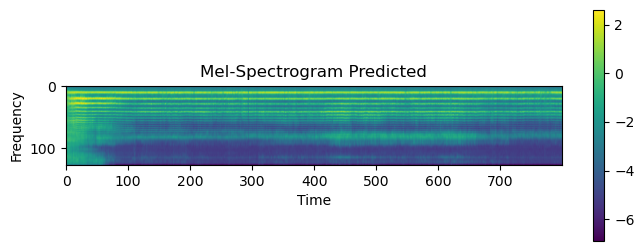

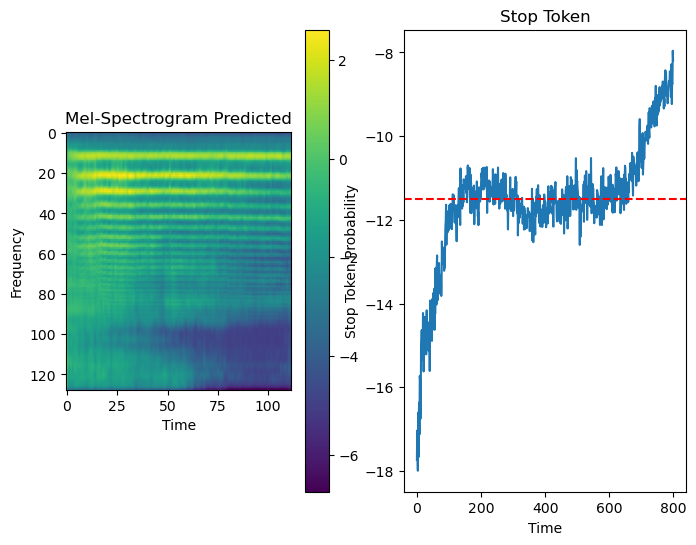

In [15]:
import torch
import torchaudio
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython
import numpy as np

transformertts = TransformerTTSInference.from_hparams(
    source="./result/save/CKPT+2024-04-26+21-15-52+00/", hparams_file="../../Inferencehyperparams.yaml"
).to("cpu")

mel_postnet,stop_token_outputs = transformertts.infer("hello world!")

def dbToPowerMelSpec(mel_spec):
        mel_spec = mel_spec*10
        mel_spec = torchaudio.functional.DB_to_amplitude(
            mel_spec,
            ref=1,
            power=1.0
        )
        return mel_spec

InverseMelTransform = torchaudio.transforms.InverseMelScale(
        n_mels=128,
        sample_rate=22050,
        n_stft=1025
        )

griffnlimTransform = torchaudio.transforms.GriffinLim(
            n_fft=2048,
            win_length=1024,
            hop_length=256
        )

def inverse_mel_spec_to_wav(mel_spec):
        power_mel_spec = dbToPowerMelSpec(mel_spec)
        spectrogram = InverseMelTransform(power_mel_spec)
        generated_wav = griffnlimTransform(spectrogram)
        return generated_wav


# Threshold candidates to evaluate (experiment with different ranges based on your data)
thresholds = np.linspace(min(stop_token_outputs.detach().cpu().numpy()[0].T), max(stop_token_outputs.detach().cpu().numpy()[0].T), 100)

# Initialize variables to store results
horizontal_deviations = []
best_threshold = None
min_deviation = np.inf

for threshold in thresholds:
  # Calculate the deviation from the horizontal line (y-axis) for each stop token value
  deviations = np.abs(stop_token_outputs.detach().cpu().numpy()[0].T - threshold)
  # Average deviation for this threshold
  avg_deviation = np.mean(deviations)
  horizontal_deviations.append(avg_deviation)

  # Keep track of the threshold with the least deviation (most horizontal)
  if avg_deviation < min_deviation:
    min_deviation = avg_deviation
    best_threshold = threshold

stop_token_threshold = best_threshold

stop_token_mask = stop_token_outputs[0,:] > stop_token_threshold
cut_index = torch.where(stop_token_mask)[0][0]

# Plot mel-spectrogram-db
fig, ax1 = plt.subplots(figsize=(8, 3), ncols=1)
ax1.set_title("Mel-Spectrogram Predicted")
pos = ax1.imshow(mel_postnet.detach().cpu().numpy()[0].T)
fig.colorbar(pos, ax=ax1)
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency")

plt.show()

pseudo_wav = inverse_mel_spec_to_wav(mel_postnet.detach().cpu()[0].T)

plt.close()

mel_postnet_cut = mel_postnet[:, :cut_index]
pseudo_wav_cut = pseudo_wav[:cut_index * 256]  # Adjust the hop length if needed

fig, (ax1, ax2) = plt.subplots(figsize=(8, 6), ncols=2)
ax1.set_title("Mel-Spectrogram Predicted")
pos = ax1.imshow(mel_postnet_cut.detach().cpu().numpy().T)
fig.colorbar(pos, ax=ax1)
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency")

ax2.set_title("Stop Token")
ax2.plot(stop_token_outputs[0, :].detach().cpu().numpy())
ax2.axhline(y=stop_token_threshold, color='r', linestyle='--')
ax2.set_xlabel("Time")
ax2.set_ylabel("Stop Token Probability")
plt.show()

IPython.display.Audio(
    pseudo_wav_cut.detach().cpu().numpy(),
    rate=22050
)


## ANALYSIS OF RESULTS

TEST LOSS: 0.172

TRAIN LOSS: 0.191

VALID LOSS: 0.195

IMPORTANT : I HAVE TRIED MY BEST POSSIBLE WAYS TO FIND RESOURCES I HAVE BOUGHT GOOGLE COLAB PRO AND GOT SOME UNITS OF V100 TRAINED TTS UPTO 175 EPOCHES THEN THE SESSION GETS EXPIRED IN BETWEEN I HAVE TRIED DIFFERENT BATCH SIZEl, LEARNING RATE EVEN LEARNING RATE ANNEALING BUT NOT ABLE TO RUN MORE EPOCHS BEACUASE OF LESS NUMBER OF UNITS AVAILABLE (LIMITED RESOURCES).

#### Results of Transformer based TTS model and Tacatron2 of speechbrain

* The graphs demonstrate successful training of both the Tacotron2 and TTS
models, with decreasing losses on both training and validation data.
* The TTS model appears to have a slight edge in terms of lower validation loss, suggesting better generalization capabilities compared to the Tacotron2 model in less number of epochs.


In comparing this two model everything is kept similar batch size, seed and even the learning rate


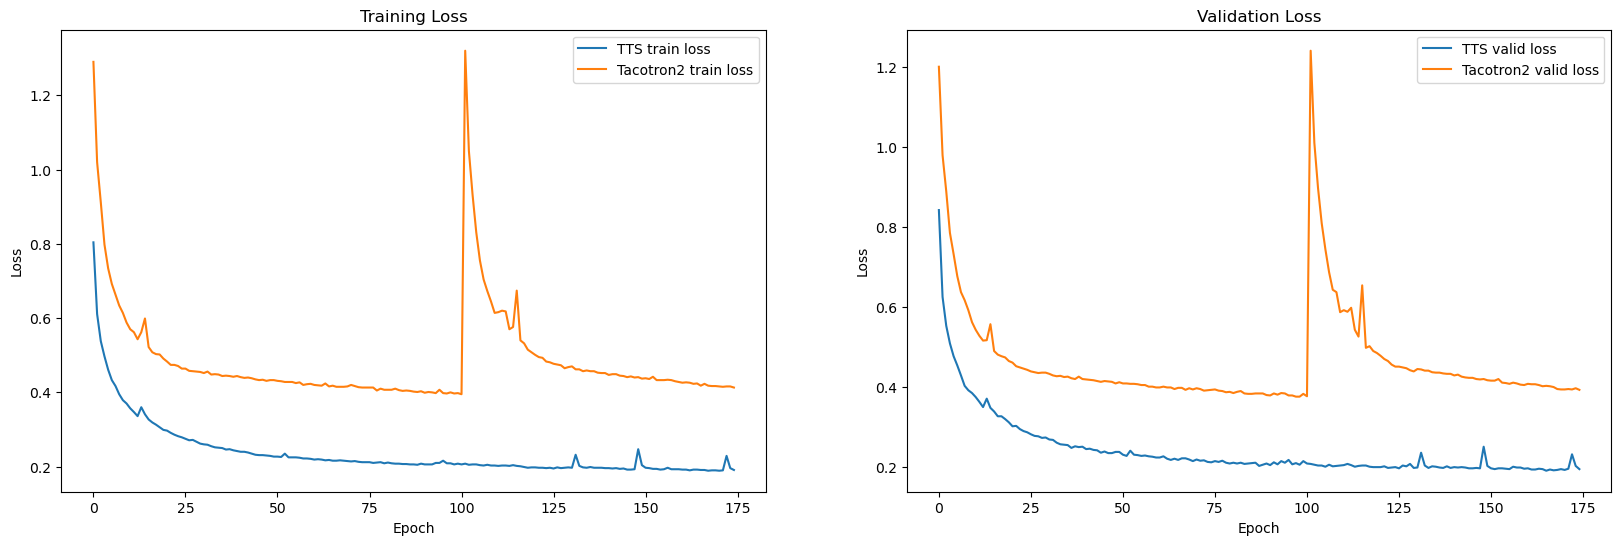

In [16]:
tts_losses = {"train": [], "train_mel": [], "valid": [], "valid_mel": []}
tacotron2_losses = {"train": [], "train_mel": [], "valid": [], "valid_mel": []}
tts_log_path = "./result/train_log.txt"
tacotron2_log_path = "./train_log.txt"

# Open the TTS log file
with open(tts_log_path, "r") as file:
    # Read each line in the file
    for line in file:
        if "test" in line:
            continue
        # Split the line by comma and extract relevant parts
        parts = line.split(",")
        # Extract train loss and valid loss from the relevant parts
        train_loss = float(parts[1].split(" ")[-1].strip())
        valid_loss = float(parts[3].split(" ")[-1].strip())
        # Append the extracted values to the respective lists
        tts_losses["train"].append(train_loss)
        tts_losses["valid"].append(valid_loss)

# Open the Tacotron2 log file
with open(tacotron2_log_path, "r") as file:
    # Read each line in the file
    for line in file:
        if "test" in line:
            continue
        # Split the line by comma and extract relevant parts
        parts = line.split(",")
        # Extract train loss and valid loss from the relevant parts
        train_loss = float(parts[1].split(" ")[-1].strip())
        valid_loss = float(parts[5].split(" ")[-1].strip())
        # Append the extracted values to the respective lists
        tacotron2_losses["train"].append(train_loss)
        tacotron2_losses["valid"].append(valid_loss)

# Truncate the Tacotron2 losses to match the length of the TTS losses
tacotron2_losses["train"] = tacotron2_losses["train"][:len(tts_losses["train"])]
tacotron2_losses["valid"] = tacotron2_losses["valid"][:len(tts_losses["valid"])]

# Plot the training and validation loss for both models side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(tts_losses["train"], label="TTS train loss")
axs[0].plot(tacotron2_losses["train"], label="Tacotron2 train loss")
axs[0].set_title("Training Loss")
axs[0].set(xlabel="Epoch", ylabel="Loss")
axs[0].legend()
axs[1].plot(tts_losses["valid"], label="TTS valid loss")
axs[1].plot(tacotron2_losses["valid"], label="Tacotron2 valid loss")
axs[1].set_title("Validation Loss")
axs[1].set(xlabel="Epoch", ylabel="Loss")
axs[1].legend()
plt.show()

#### Results with batch size 8 compared with batch size 32

* The larger batch size of 32 appears to perform better in terms of both training and validation losses, potentially due to more efficient optimization and better generalization capabilities. But can't conclude unless we run same number of epoch on both

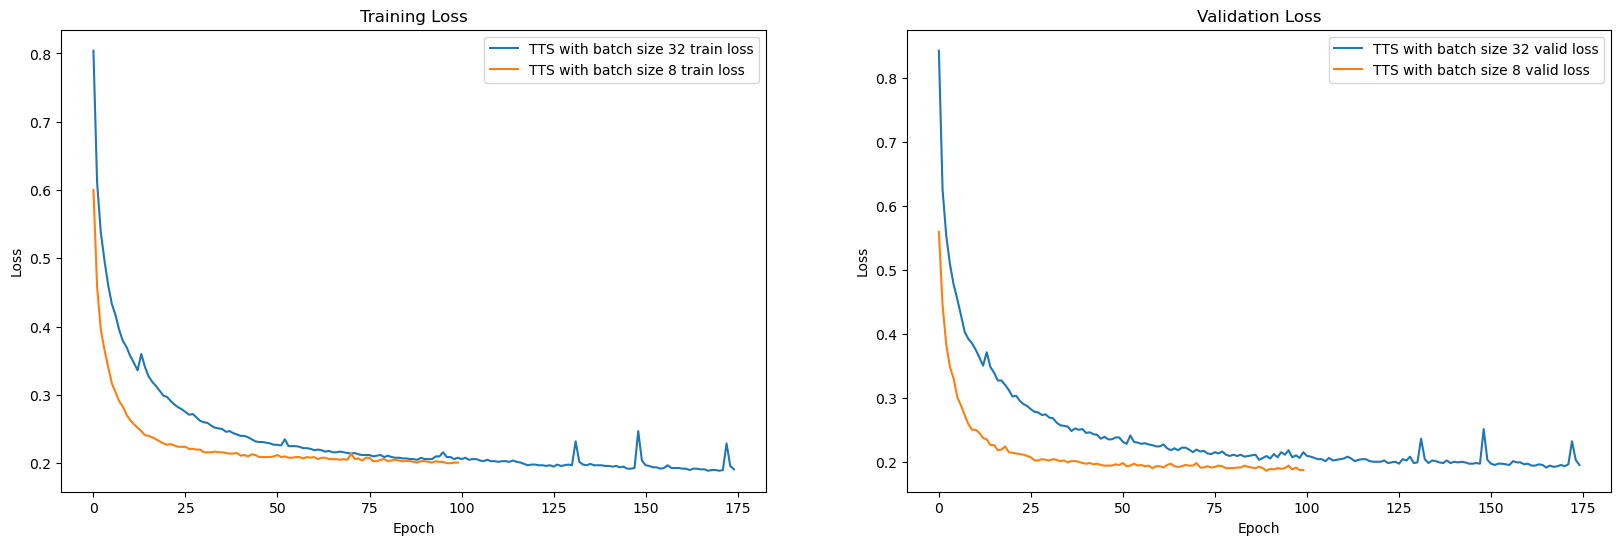

In [17]:
tts_losses = {"train": [], "train_mel": [], "valid": [], "valid_mel": []}
tts_batch_size_8_losses = {"train": [], "train_mel": [], "valid": [], "valid_mel": []}

tts_log_path = "./result/train_log.txt"
tts_batch_size_8_log_path = "./train_log_batchsize_8.txt"

# Open the TTS log file
with open(tts_log_path, "r") as file:
    # Read each line in the file
    for line in file:
        if "test" in line:
            continue
        # Split the line by comma and extract relevant parts
        parts = line.split(",")
        # Extract train loss and valid loss from the relevant parts
        train_loss = float(parts[1].split(" ")[-1].strip())
        valid_loss = float(parts[3].split(" ")[-1].strip())
        # Append the extracted values to the respective lists
        tts_losses["train"].append(train_loss)
        tts_losses["valid"].append(valid_loss)

# Open the TTS with batch size 8 log file
with open(tts_batch_size_8_log_path, "r") as file:
    # Read each line in the file
    for line in file:
        if "test" in line:
            continue
        # Split the line by comma and extract relevant parts
        parts = line.split(",")
        # Extract train loss and valid loss from the relevant parts
        train_loss = float(parts[1].split(" ")[-1].strip())
        valid_loss = float(parts[3].split(" ")[-1].strip())
        # Append the extracted values to the respective lists
        tts_batch_size_8_losses["train"].append(train_loss)
        tts_batch_size_8_losses["valid"].append(valid_loss)

# tts_losses["train"] = tts_losses["train"][:len(tts_batch_size_8_losses["train"])]
# tts_losses["valid"] = tts_losses["valid"][:len(tts_batch_size_8_losses["valid"])]

# Plot the training and validation loss for both models side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(tts_losses["train"], label="TTS with batch size 32 train loss")
axs[0].plot(tts_batch_size_8_losses["train"], label="TTS with batch size 8 train loss")
axs[0].set_title("Training Loss")
axs[0].set(xlabel="Epoch", ylabel="Loss")
axs[0].legend()
axs[1].plot(tts_losses["valid"], label="TTS with batch size 32 valid loss")
axs[1].plot(tts_batch_size_8_losses["valid"], label="TTS with batch size 8 valid loss")
axs[1].set_title("Validation Loss")
axs[1].set(xlabel="Epoch", ylabel="Loss")
axs[1].legend()
plt.show()


### Learning rate annealing

* The varying LR model appears to have better performance in the end but I am not able to train the model due to limited resources

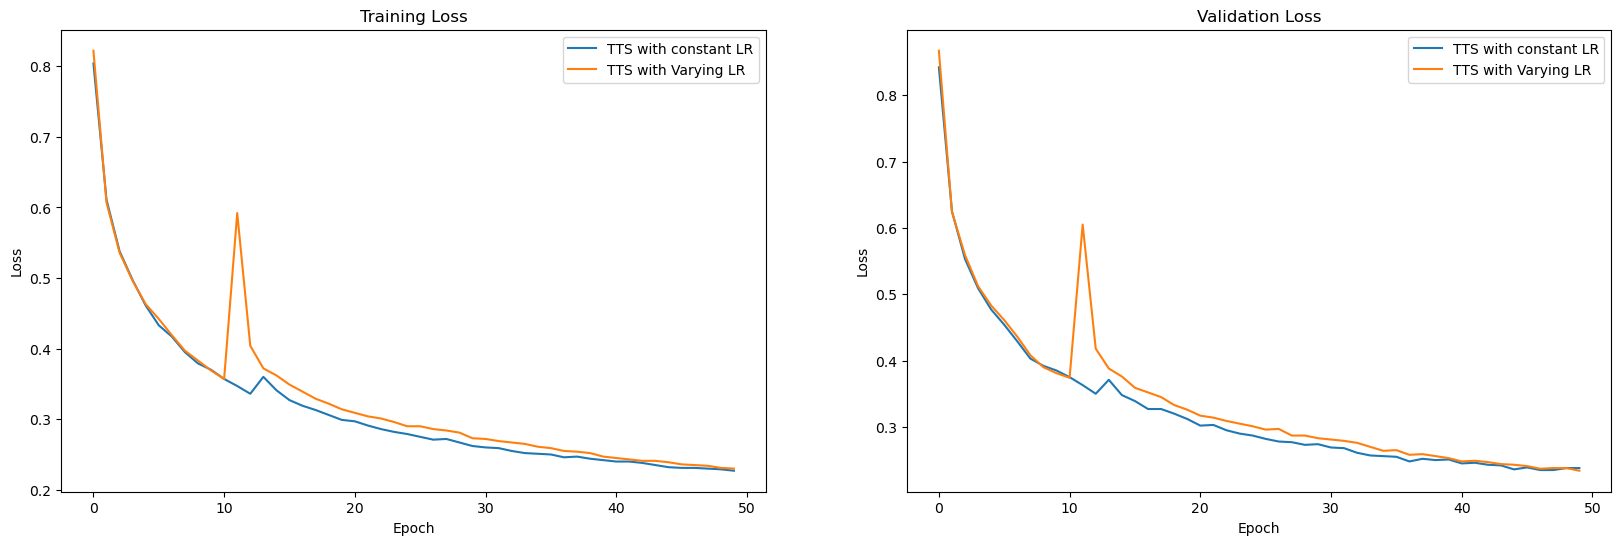

In [19]:
tts_losses = {"train": [], "train_mel": [], "valid": [], "valid_mel": []}
tts_lr_annealing_losses = {"train": [], "train_mel": [], "valid": [], "valid_mel": []}

tts_log_path = "./result/train_log.txt"
tts_lr_annealing_losses_path = "./lr_annelling.txt"

# Open the TTS log file
with open(tts_log_path, "r") as file:
    # Read each line in the file
    for line in file:
        if "test" in line:
            continue
        # Split the line by comma and extract relevant parts
        parts = line.split(",")
        # Extract train loss and valid loss from the relevant parts
        train_loss = float(parts[1].split(" ")[-1].strip())
        valid_loss = float(parts[3].split(" ")[-1].strip())
        # Append the extracted values to the respective lists
        tts_losses["train"].append(train_loss)
        tts_losses["valid"].append(valid_loss)

# Open the TTS with batch size 8 log file
with open(tts_lr_annealing_losses_path, "r") as file:
    # Read each line in the file
    for line in file:
        if "test" in line:
            continue
        # Split the line by comma and extract relevant parts
        parts = line.split(",")
        # Extract train loss and valid loss from the relevant parts
        train_loss = float(parts[1].split(" ")[-1].strip())
        valid_loss = float(parts[3].split(" ")[-1].strip())
        # Append the extracted values to the respective lists
        tts_lr_annealing_losses["train"].append(train_loss)
        tts_lr_annealing_losses["valid"].append(valid_loss)


tts_losses["train"] = tts_losses["train"][:len(tts_lr_annealing_losses["train"])]
tts_losses["valid"] = tts_losses["valid"][:len(tts_lr_annealing_losses["valid"])]

# Plot the training and validation loss for both models side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(tts_losses["train"], label="TTS with constant LR")
axs[0].plot(tts_lr_annealing_losses["train"], label="TTS with Varying LR")
axs[0].set_title("Training Loss")
axs[0].set(xlabel="Epoch", ylabel="Loss")
axs[0].legend()
axs[1].plot(tts_losses["valid"], label="TTS with constant LR")
axs[1].plot(tts_lr_annealing_losses["valid"], label="TTS with Varying LR")
axs[1].set_title("Validation Loss")
axs[1].set(xlabel="Epoch", ylabel="Loss")
axs[1].legend()
plt.show()


## CONCLUSION

Experimenting with Transformer-based Text-to-Speech (TTS) models and Tacotron2 within the SpeechBrain framework has given useful insights, despite substantial resource constraints. Here's an overview of the important results and their implications:


### 1. Model Performance Comparison

* Both the Transformer TTS and Tacotron2 models trained well, as shown by lower losses on training and validation data.
* The Transformer TTS model outperformed Tacotron2 by a little percentage, indicating possibly higher generalisation capabilities.




#### 2. Batch Size Impact:

* Comparing different batch sizes revealed that a larger batch size of 32 tended to outperform a batch size of 8 in terms of training and validation losses.
* This suggests that larger batch sizes may facilitate more efficient optimization and enhanced generalization.
* Nonetheless, considerations regarding computational resources must be weighed against the benefits of larger batch sizes, as they may require more memory and computational power.




#### 3. Learning Rate Annealing:

* Experimentation with varying learning rates demonstrated potential benefits towards the end of training.
* Learning rate annealing may contribute to improved model performance, but conclusive evidence was hindered by resource constraints.


#### 4. Resource Limitations and Future Directions:

* Limited computational resources, including the constraints of Google Colab Pro and V100 GPU units, impeded the ability to train models for an extended number of epochs.
* To overcome these limitations and draw more definitive conclusions, future work should explore alternative computational resources or distributed training setups.
* Implementation on Phoneme based approch as well as use of vocoders architecture and can also explore VIT.


## Acknowledgement

I wanted to take a moment to express my sincere gratitude to each of you for your support and guidance throughout my journey in Conversational AI. Special thanks to our Teaching Assistants for their invaluable help in bug detection and suggestions. Your dedication has been truly appreciated. A heartfelt thank you to our esteemed Professor for structuring the project as standalone, which has immensely facilitated my learning.


